In [1]:
%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

# from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
#from utils import variable
# from generate_masks import get_model
#from unet_models import unet11_MS

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

# import the helper functions
sys.path.append('../')
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

In [33]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # aws
gt_image_2 = '../../../smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../../../smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_0_5_wgs84_SnapR.tif' # aws

# specify the shapefile
shpfile = '../union/union.shp' # aws
shpfile = '../../../smart_cities/Denver_Sample_Sites/union/union.shp' #desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [3]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
img_2m_toa = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=False)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\gbdxtools\images\meta.py:21: UserWarning: ShareDict has been deprecated in favor of HighLevelGraph and will be removed in future versions
  from dask import sharedict, optimization


In [5]:
print(image_05m.mean(axis=1).mean(axis=1).compute())
for i in range(8):
    print(image_05m[i,:,:].std().compute())

[ 878.37506 1038.793   1264.5168  1409.1903  1464.208   2063.0278
 2600.2441  2722.5916 ]
708.204
823.8164
874.04956
973.51953
1022.4793
997.7366
1270.3091
1340.9843


# Export image chips

In [4]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 1000
side = 256

In [10]:
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        ran_rowP = ran_row * pan_factorR
        ran_colP  = ran_col * pan_factorC
        
        # check that row and col are within image bounds given side first. 
        rc_flag = ((ran_row - int(side/2)) > 0) and ((ran_row + int(side/2)) < rows) and \
                  ((ran_col - int(side/2)) > 0) and ((ran_col + int(side/2)) < cols) and \
                  ((ran_rowP - int(side*pan_factorR/2)) > 0) and ((ran_rowP + int(side*pan_factorR/2)) < rowsP) and \
                  ((ran_colP - int(side*pan_factorC/2)) > 0) and ((ran_colP + int(side*pan_factorC/2)) < colsP)
        
        while not rc_flag:
            ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
            ran_rowP = ran_row * pan_factorR
            ran_colP  = ran_col * pan_factorC
            
            # check that row and col are within image bounds given side first. 
            rc_flag = ((ran_row - int(side/2)) > 0) and ((ran_row + int(side/2)) < rows) and \
                      ((ran_col - int(side/2)) > 0) and ((ran_col + int(side/2)) < cols) and \
                      ((ran_rowP - int(side*pan_factorR/2)) > 0) and ((ran_rowP + int(side*pan_factorR/2)) < rowsP) and \
                      ((ran_colP - int(side*pan_factorC/2)) > 0) and ((ran_colP + int(side*pan_factorC/2)) < colsP)

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt, window_size=side)
            ct = 0
            while pt_flag:
                
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                ran_rowP = ran_row * pan_factorR
                ran_colP  = ran_col * pan_factorC

                # check that row and col are within image bounds given side first. 
                rc_flag = ((ran_row - int(side/2)) > 0) and ((ran_row + int(side/2)) < rows) and \
                          ((ran_col - int(side/2)) > 0) and ((ran_col + int(side/2)) < cols) and \
                          ((ran_rowP - int(side*pan_factorR/2)) > 0) and ((ran_rowP + int(side*pan_factorR/2)) < rowsP) and \
                          ((ran_colP - int(side*pan_factorC/2)) > 0) and ((ran_colP + int(side*pan_factorC/2)) < colsP)
                
                while not rc_flag:
                    ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                    ran_rowP = ran_row * pan_factorR
                    ran_colP  = ran_col * pan_factorC

                    # check that row and col are within image bounds given side first. 
                    rc_flag = ((ran_row - int(side/2)) > 0) and ((ran_row + int(side/2)) < rows) and \
                              ((ran_col - int(side/2)) > 0) and ((ran_col + int(side/2)) < cols) and \
                              ((ran_rowP - int(side*pan_factorR/2)) > 0) and ((ran_rowP + int(side*pan_factorR/2)) < rowsP) and \
                              ((ran_colP - int(side*pan_factorC/2)) > 0) and ((ran_colP + int(side*pan_factorC/2)) < colsP)
                
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt, window_size=side)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

In [11]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

In [12]:
# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
# with rasterio.open(gt_image_05, 'r') as src:

#     # cull the lon/lat points by checking if they include nodata pixels
#     gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]

In [13]:
## optionally load text file
#coords = np.loadtxt('../debug_IS_segmentation/dg_support_coords.txt')
#num = coords.shape[0]
len(coords)
coords

[(1074, 1871),
 (1241, 2710),
 (1485, 544),
 (980, 1800),
 (1240, 2196),
 (1329, 2055),
 (1532, 2462),
 (1428, 1774),
 (721, 1966),
 (1423, 1343),
 (1308, 993),
 (648, 1599),
 (2030, 2758),
 (681, 2004),
 (556, 1722),
 (1430, 2206),
 (570, 1878),
 (1345, 2660),
 (1478, 2437),
 (797, 1747),
 (1263, 1899),
 (2139, 2959),
 (1089, 2447),
 (1492, 474),
 (1736, 2497),
 (1043, 1475),
 (1157, 1911),
 (1204, 2074),
 (1079, 1657),
 (1808, 2619),
 (1398, 1429),
 (1134, 1976),
 (1702, 2951),
 (1342, 2668),
 (1624, 2499),
 (1531, 1156),
 (302, 1727),
 (785, 2332),
 (824, 1389),
 (781, 2141),
 (1414, 672),
 (596, 1821),
 (1849, 2959),
 (1810, 2474),
 (1773, 2626),
 (1273, 914),
 (175, 1621),
 (798, 2013),
 (1731, 2956),
 (1187, 2185),
 (405, 1415),
 (1001, 2181),
 (1582, 2840),
 (1328, 2561),
 (1582, 2517),
 (1777, 3024),
 (1375, 760),
 (141, 1633),
 (1493, 2727),
 (864, 2193),
 (1226, 1901),
 (1649, 2495),
 (630, 1849),
 (2075, 2740),
 (1594, 681),
 (1923, 2875),
 (1447, 2677),
 (1299, 532),
 (1370

In [34]:
val_test_percentage = 0.4
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind

## load the data
coords = np.loadtxt(r'D:\projects\RD\debug_IS_segmentation\image_coords_256x256.txt')
coords_pan = np.loadtxt(r'D:\projects\RD\debug_IS_segmentation\image_coords_1064x1064.txt')

#DG
# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1460.1287, 1452.7002, 1511.6293, 2497.181], 
              std=[672.7396, 743.9062, 918.4014, 1196.6774])
])

# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1545.9403, 1460.1287, 1452.7002, 1466.6466, 1511.6293, 1902.1776, 2497.181, 2167.458], 
              std=[512.423, 672.7396, 743.9062, 840.52625, 918.4014, 828.56976, 1196.6774, 1061.4962])
])

img_transform_PS = Compose([
    Normalize(mean=[878.37506, 1038.793, 1264.5168, 1409.1903, 1464.208, 2063.0278, 2600.2441, 2722.5916],
              std=[708.204, 823.8164, 874.04956, 973.51953, 1022.4793, 997.7366, 1270.3091, 1340.9843])
])

# ground truth
gt_transform = Compose([
    ToTensor()
    ])

dg_transform = Compose([])

mode = 'PS'
# mode = 'MS'
if mode == 'PS':
    gt_im = gt_image_05
    dg_im = image_05m/10000
    use_coords = coords_pan
    winsize = side * min(pan_factorC, pan_factorR)
    winsize = 512 # something off about above
    img_transform=img_transform_PS
    img_transform=dg_transform
    
else:
    gt_im = gt_image_2
    dg_im = img_2m/10000
    use_coords = coords
    winsize=side
    img_transform=gt_transform # for use with dividing image by 10000
    
    

dg_dataset_train = DigitalGlobeSamplerTensor(dg_im, use_coords[:train_ind], transform=dg_transform, window_size=winsize, comb='all') # will return RGB by default
dg_dataset_val = DigitalGlobeSamplerTensor(dg_im, use_coords[train_ind:val_ind], transform=dg_transform, window_size=winsize, comb='all')
dg_dataset_test = DigitalGlobeSamplerTensor(dg_im, use_coords[val_ind:], transform=dg_transform, window_size=winsize, comb='all')

gt_dataset_train = gtDatasetSampler2(gt_im, use_coords[:train_ind], transform=gt_transform, window_size=winsize) 
gt_dataset_val = gtDatasetSampler2(gt_im, use_coords[train_ind:val_ind], transform=gt_transform, window_size=winsize)
gt_dataset_test = gtDatasetSampler2(gt_im, use_coords[val_ind:], transform=gt_transform, window_size=winsize)




torch.Size([8, 512, 512])


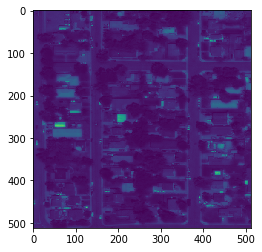

In [35]:
ind = 2#, print(coords[ind])
print(dg_dataset_train[ind].shape)
gt_dataset_train[ind].shape
#gt_dataset_train[ind].shape
plt.imshow(dg_dataset_train[ind][0,:,:])


In [36]:
# some functions to write the data
def gt_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 1,
        "dtype": rio.uint8,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename

def dg_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 8,
        "dtype": rio.float32,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename


# iterate over the data
cnt=0
for chipset, typ in zip( ((gt_dataset_train, dg_dataset_train), (gt_dataset_val, dg_dataset_val), (gt_dataset_test, dg_dataset_test)), ('train', 'val', 'test') ):
    
    # construct the base folder
    if mode == 'PS':
        base_folder = '../../debug_IS_segmentation/tilesPS_d10000_{}x{}/{}'.format(winsize,winsize,typ) #desktop
    else:
        base_folder = '../../debug_IS_segmentation/tiles_d10000_{}x{}/{}'.format(winsize,winsize,typ) #desktop
    
    if not os.path.exists(base_folder):
        print('creating', base_folder)
        os.makedirs(base_folder)
        
    # separate the chipsets
    gt_set, dg_set = chipset
    
    print('chipping {} set'.format(typ))
    # iterate over the chipsets
    #for gt_tensor, dg_tensor in zip(gt_set, dg_set):
    for i in range(len(gt_set)):
        
        try:
            gt_tensor=gt_set[i]
            dg_tensor=dg_set[i]
            
            # write out the ground truth rasters
            gt_name = 'gt_is_{0:05d}.tif'.format(cnt)
            gt_fi = os.path.join(base_folder, gt_name)
            gt_write(gt_fi, gt_tensor.numpy().astype('uint8'))

            # write out the dg rasters
            dg_name = 'dg_is_{0:05d}.tif'.format(cnt)
            dg_fi = os.path.join(base_folder, dg_name)
            dg_write(dg_fi, dg_tensor.numpy().astype('float32'))
        
            cnt+=1
            
        except:
            print('skipping index {}'.format(i))
            cnt+=1
            continue
    
        
        
        
        
        


chipping train set
creating ../../debug_IS_segmentation/tilesPS_d10000_512x512/val
chipping val set
creating ../../debug_IS_segmentation/tilesPS_d10000_512x512/test
chipping test set


600

In [33]:
## save the points
np.savetxt('../../debug_IS_segmentation/image_coords_256x256.txt',np.array(coords))
np.savetxt( '../../debug_IS_segmentation/lonlat_MS_coords_256x256.txt',np.array(lonlat_MS))

## save the points
np.savetxt('../../debug_IS_segmentation/image_coords_1064x1064.txt',np.array(coords_pan))
np.savetxt( '../../debug_IS_segmentation/lonlat_PAN_coords_1064x1064.txt',np.array(lonlat_PAN))

# CODE FOR 64x64 windows!

In [6]:
# save based on coords index and original data
cnt=0
window_size=64
for i,coord in enumerate(coords):
    if i < 8000:
        print('saving training')
        typ='train'
        base_folder = '../debug_IS_segmentation/tiles_64x64/sr/{}'.format(typ) #desktop
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        
    elif i < 9000:
        print('saving val')
        typ='val'
        base_folder = '../debug_IS_segmentation/tiles_64x64/sr/{}'.format(typ) #desktop
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        
    elif i < 10000:
        print('saving test')
        typ='test'
        base_folder = '../debug_IS_segmentation/tiles_64x64/sr/{}'.format(typ) #desktop
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
    
    r,c = coord
    
    r_start = int(r - window_size/2)
    r_end = int(r_start + window_size)
    c_start = int(c - window_size/2)
    c_end = int(c_start + window_size) 
    
    # make filename
    dg_name = 'dg_is_{0:05d}.tif'.format(cnt)
    
    # save data
    test = img_2m[:,r_start:r_end, c_start:c_end]
    test.geotiff(path=os.path.join(base_folder, dg_name))
    
    cnt+=1

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving training
saving t

saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val
saving val

saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
saving test
savi

# DEBUG MISSING PIXELS

(8, 64, 64)


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


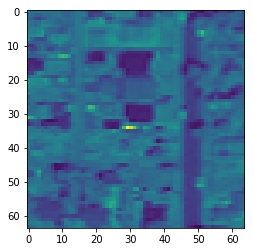

In [8]:
# gt_files = glob.glob('../tiles_64x64/train/gt*.tif')
# dg_files = glob.glob('../tiles_64x64/train/dg*.tif') # aws
dg_files = glob.glob('../debug_IS_segmentation/tiles_64x64/sr/train/dg*.tif') # desktop
ind=1

with rio.open(dg_files[ind]) as src:
    arr = src.read()
    print(arr.shape)
    
plt.imshow(arr[5])
plt.show()

# with rio.open(gt_files[ind]) as src:
#     arr = src.read()
#     print(arr.shape)
    
# plt.imshow(arr[0])

row start: 1042, row end: 1106
col start: 1839, col end: 1903
imshape: (2352, 3231)


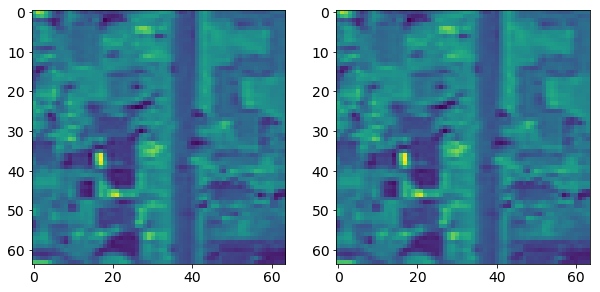

In [20]:
ind=2
r,c = coords[ind]
window_size=64
r_start = int(r - window_size/2)
r_end = int(r_start + window_size)
c_start = int(c - window_size/2)
c_end = int(c_start + window_size)

print('row start: {}, row end: {}'.format(r_start, r_end))
print('col start: {}, col end: {}'.format(c_start, c_end))
print('imshape: {}'.format(img_2m.shape[1:]))

test = img_2m[:,r_start:r_end, c_start:c_end]
test_toa = img_2m_toa[:,r_start:r_end, c_start:c_end]

fig, ax = plt.subplots(1,2)
ax[0].imshow(test[5,:,:])
ax[1].imshow(test_toa[5,:,:])
plt.show()

In [15]:
test.affine

Affine(1.7211642112827883e-05, 0.0, -105.03875758609415,
       0.0, -1.7211642112827883e-05, 39.70158674057851)

In [17]:
test.affine

Affine(1.7211642112827883e-05, 0.0, -105.01633081642113,
       0.0, -1.7211642112827883e-05, 39.71272267302552)

row start: 1366, row end: 1430
col start: 1397, col end: 1461
imshape: (2352, 3231)


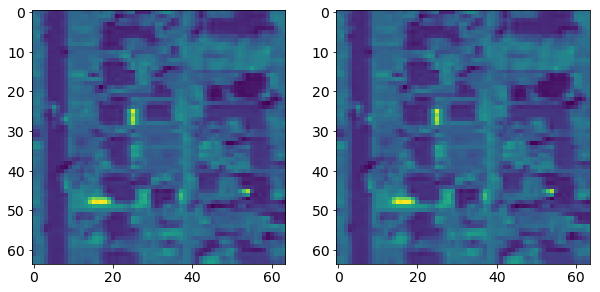

row start: 2179, row end: 2243
col start: 2916, col end: 2980
imshape: (2352, 3231)


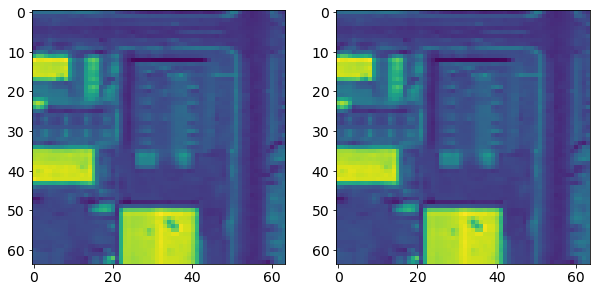

row start: 1987, row end: 2051
col start: 2817, col end: 2881
imshape: (2352, 3231)


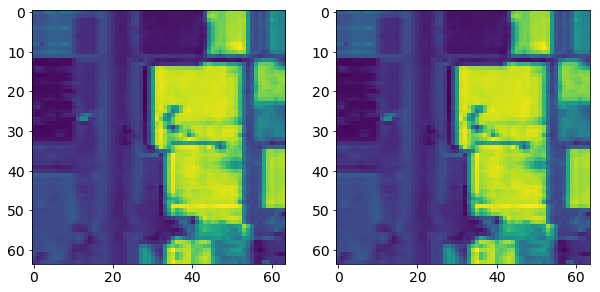

row start: 2109, row end: 2173
col start: 2841, col end: 2905
imshape: (2352, 3231)


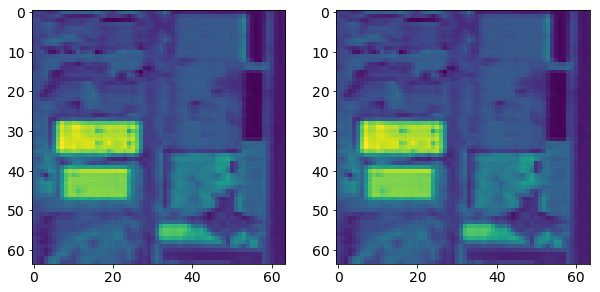

row start: 941, row end: 1005
col start: 2319, col end: 2383
imshape: (2352, 3231)


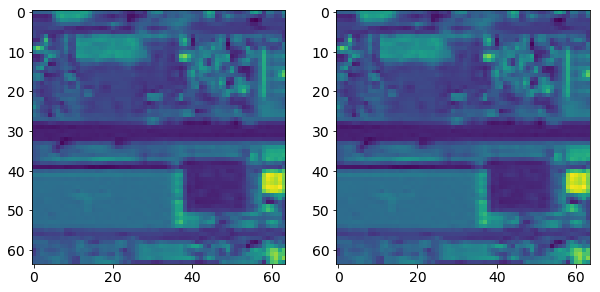

row start: 1179, row end: 1243
col start: 601, col end: 665
imshape: (2352, 3231)


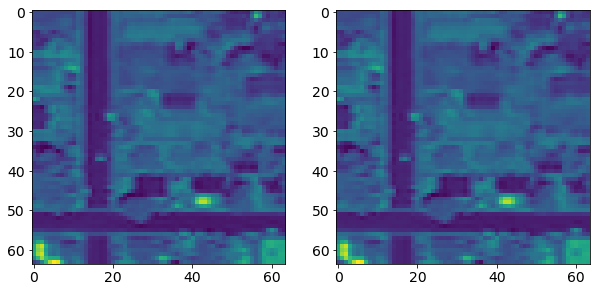

row start: 1337, row end: 1401
col start: 720, col end: 784
imshape: (2352, 3231)


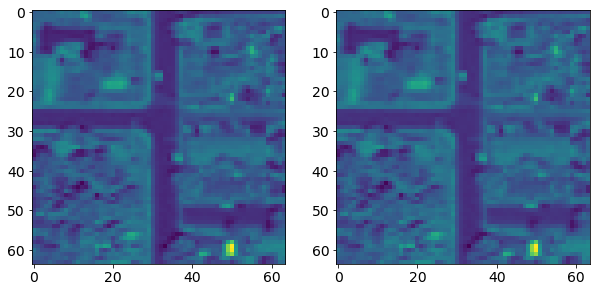

row start: 1803, row end: 1867
col start: 3118, col end: 3182
imshape: (2352, 3231)


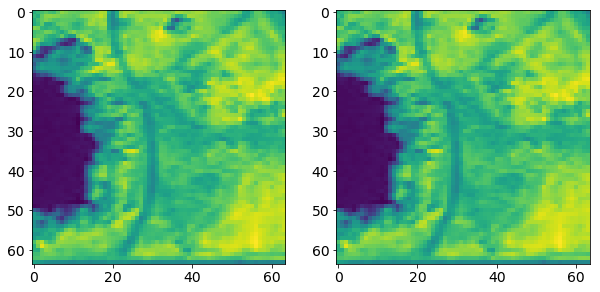

row start: 1521, row end: 1585
col start: 1297, col end: 1361
imshape: (2352, 3231)


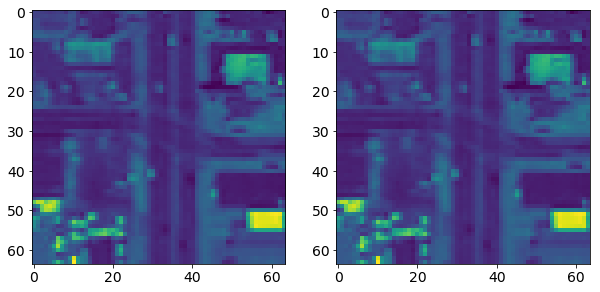

row start: 1633, row end: 1697
col start: 552, col end: 616
imshape: (2352, 3231)


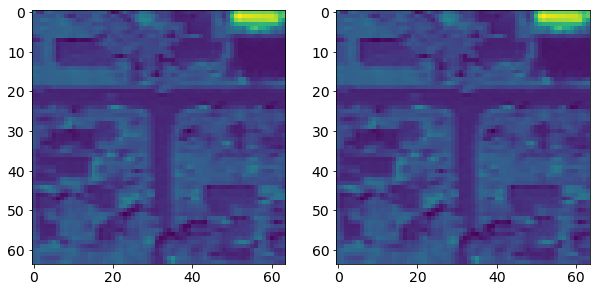

row start: 1088, row end: 1152
col start: 1182, col end: 1246
imshape: (2352, 3231)


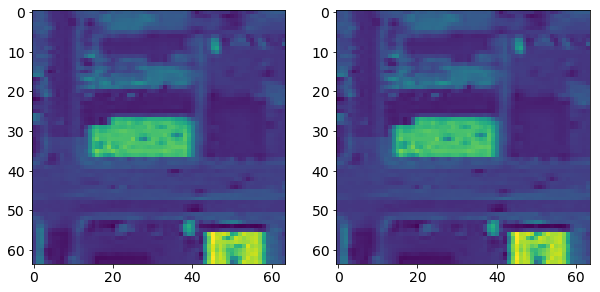

row start: 740, row end: 804
col start: 2038, col end: 2102
imshape: (2352, 3231)


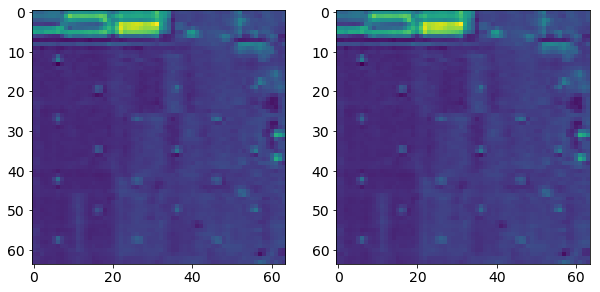

row start: 573, row end: 637
col start: 1669, col end: 1733
imshape: (2352, 3231)


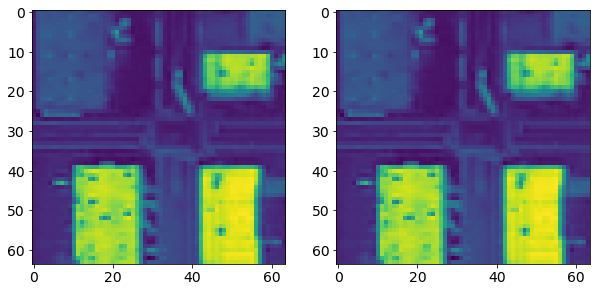

row start: 1032, row end: 1096
col start: 1731, col end: 1795
imshape: (2352, 3231)


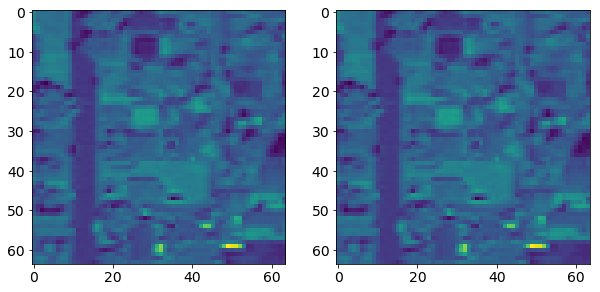

row start: 1305, row end: 1369
col start: 2181, col end: 2245
imshape: (2352, 3231)


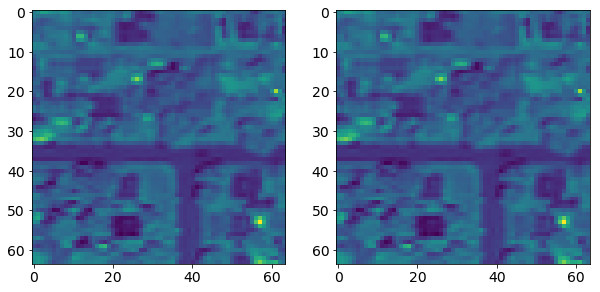

row start: 682, row end: 746
col start: 1658, col end: 1722
imshape: (2352, 3231)


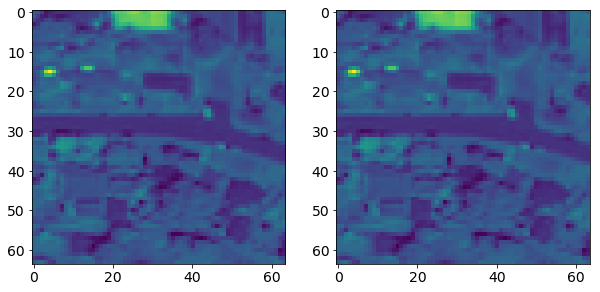

row start: 1578, row end: 1642
col start: 2889, col end: 2953
imshape: (2352, 3231)


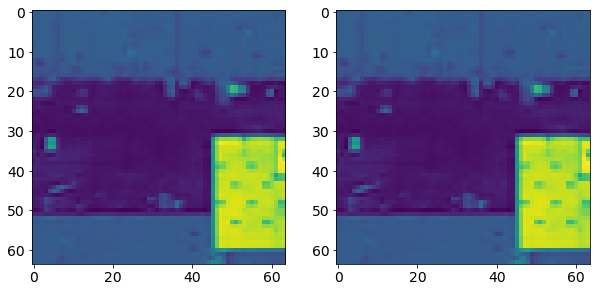

row start: 1435, row end: 1499
col start: 1914, col end: 1978
imshape: (2352, 3231)


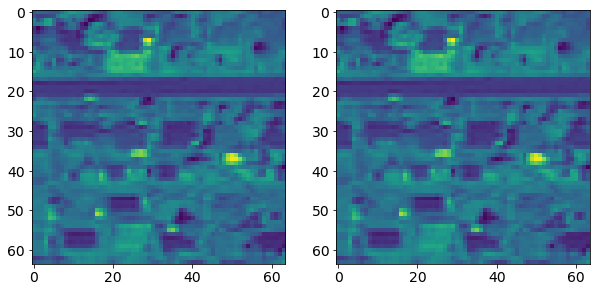

row start: 1775, row end: 1839
col start: 3079, col end: 3143
imshape: (2352, 3231)


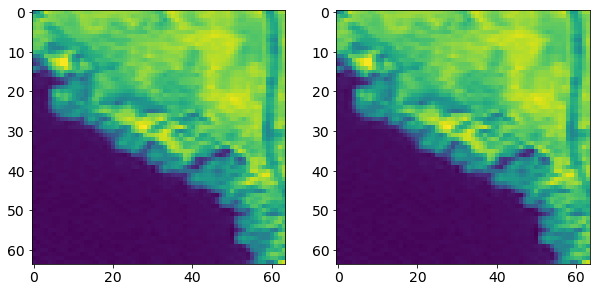

row start: 1521, row end: 1585
col start: 2371, col end: 2435
imshape: (2352, 3231)


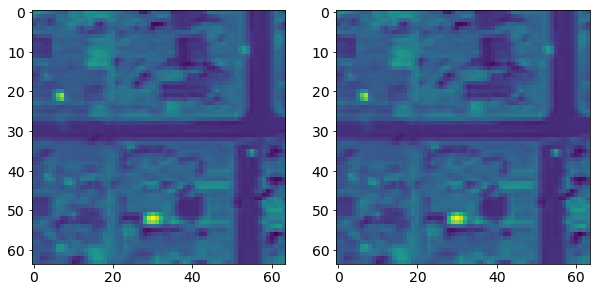

row start: 1622, row end: 1686
col start: 495, col end: 559
imshape: (2352, 3231)


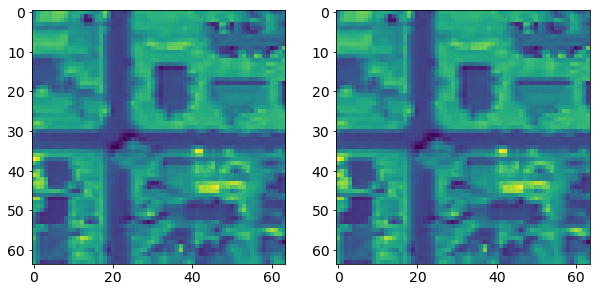

row start: 1413, row end: 1477
col start: 1269, col end: 1333
imshape: (2352, 3231)


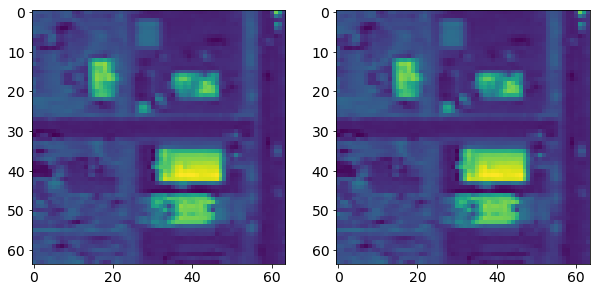

row start: 1250, row end: 1314
col start: 1255, col end: 1319
imshape: (2352, 3231)


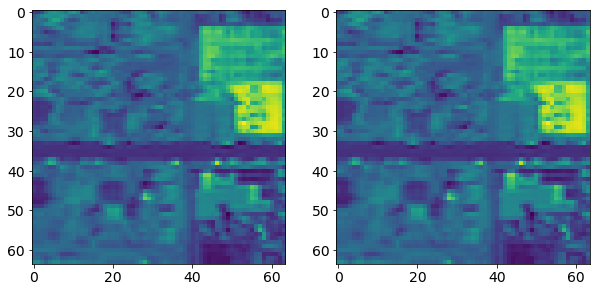

row start: 960, row end: 1024
col start: 2610, col end: 2674
imshape: (2352, 3231)


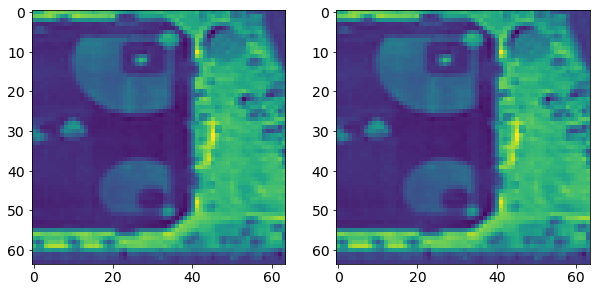

row start: 1477, row end: 1541
col start: 1547, col end: 1611
imshape: (2352, 3231)


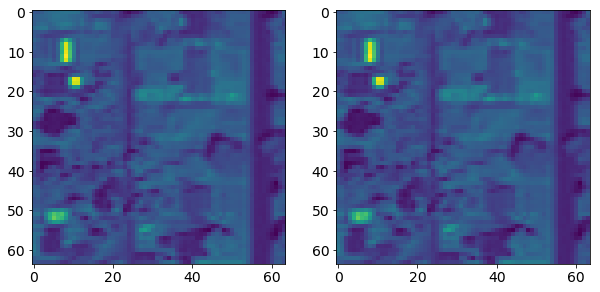

row start: 1296, row end: 1360
col start: 627, col end: 691
imshape: (2352, 3231)


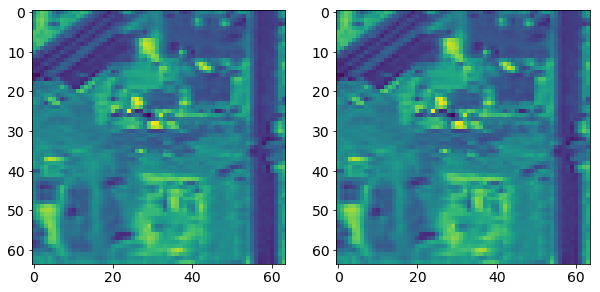

row start: 1826, row end: 1890
col start: 2883, col end: 2947
imshape: (2352, 3231)


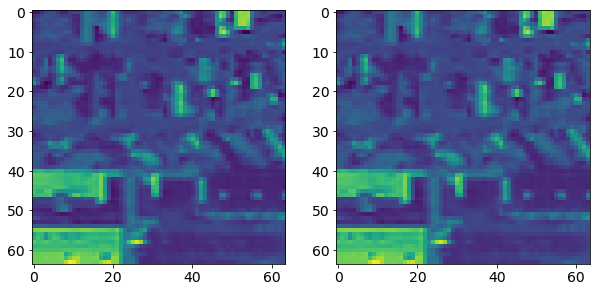

row start: 1927, row end: 1991
col start: 2880, col end: 2944
imshape: (2352, 3231)


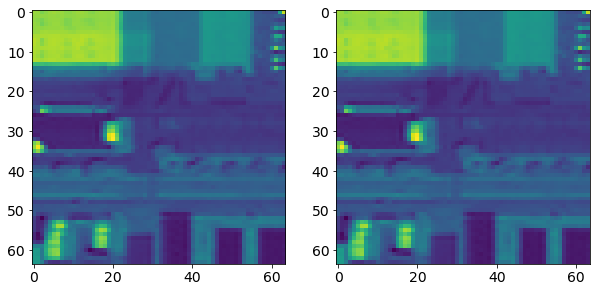

row start: 1762, row end: 1826
col start: 2637, col end: 2701
imshape: (2352, 3231)


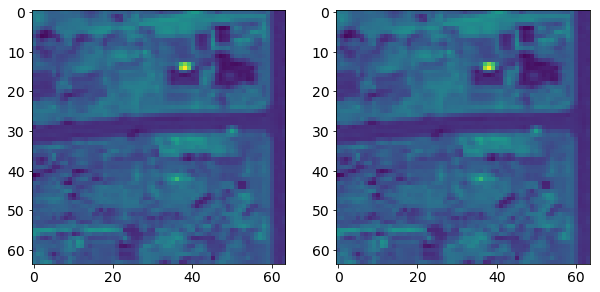

row start: 1403, row end: 1467
col start: 2617, col end: 2681
imshape: (2352, 3231)


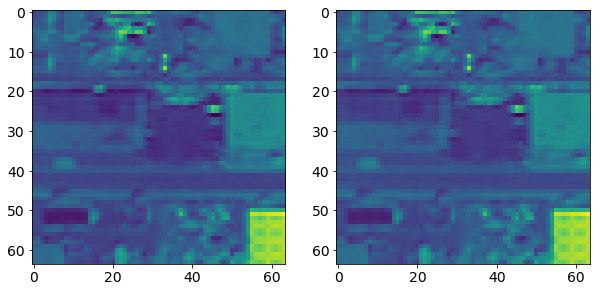

row start: 1837, row end: 1901
col start: 2611, col end: 2675
imshape: (2352, 3231)


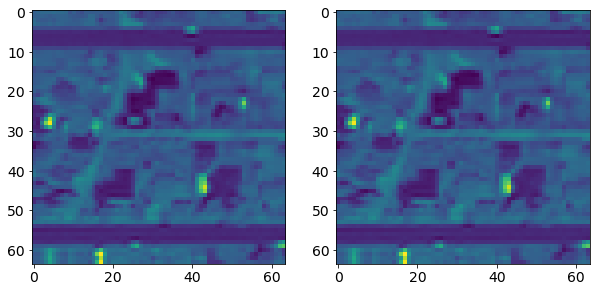

row start: 1726, row end: 1790
col start: 3053, col end: 3117
imshape: (2352, 3231)


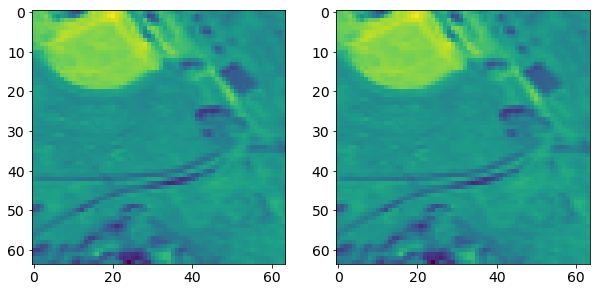

row start: 1147, row end: 1211
col start: 967, col end: 1031
imshape: (2352, 3231)


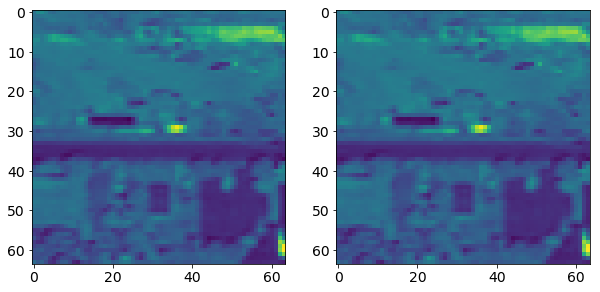

row start: 604, row end: 668
col start: 1440, col end: 1504
imshape: (2352, 3231)


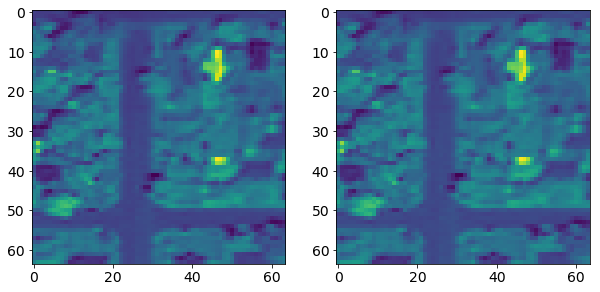

row start: 1328, row end: 1392
col start: 1213, col end: 1277
imshape: (2352, 3231)


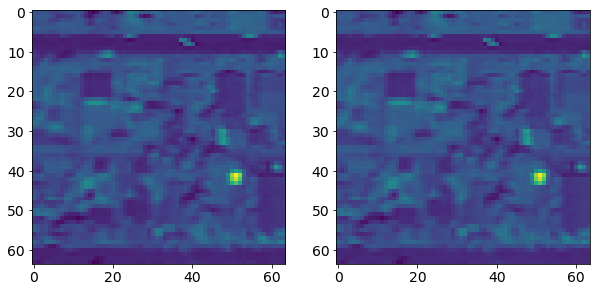

row start: 919, row end: 983
col start: 2334, col end: 2398
imshape: (2352, 3231)


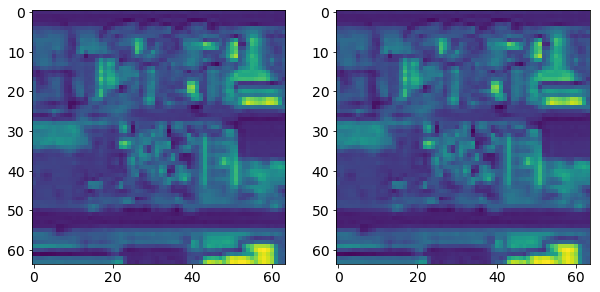

row start: 709, row end: 773
col start: 1734, col end: 1798
imshape: (2352, 3231)


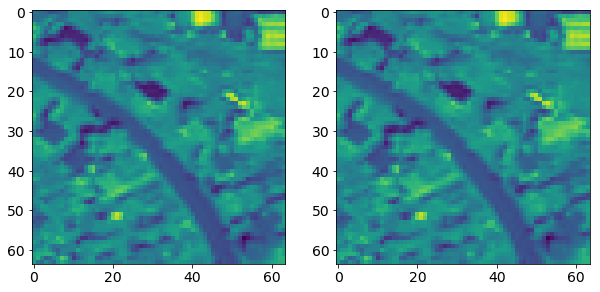

row start: 1260, row end: 1324
col start: 2580, col end: 2644
imshape: (2352, 3231)


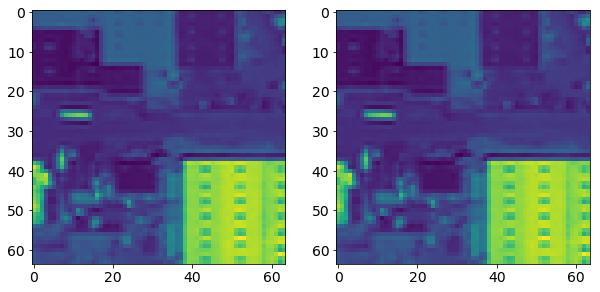

row start: 584, row end: 648
col start: 1742, col end: 1806
imshape: (2352, 3231)


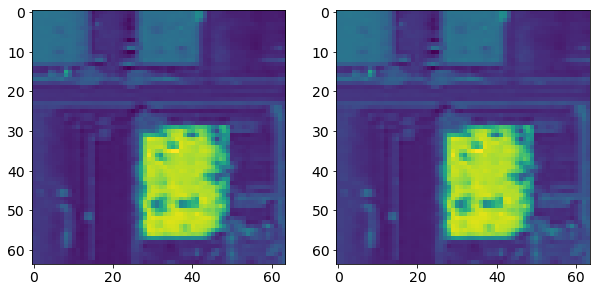

row start: 1635, row end: 1699
col start: 1054, col end: 1118
imshape: (2352, 3231)


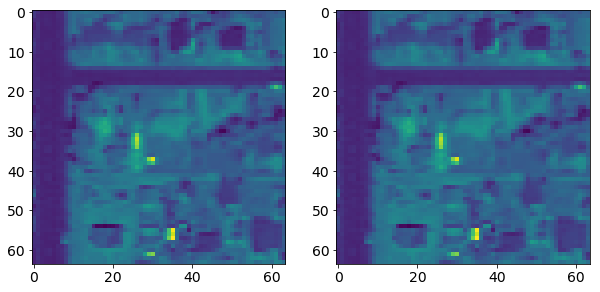

row start: 561, row end: 625
col start: 1433, col end: 1497
imshape: (2352, 3231)


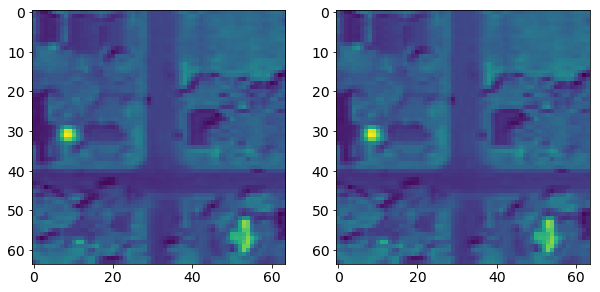

row start: 1242, row end: 1306
col start: 1976, col end: 2040
imshape: (2352, 3231)


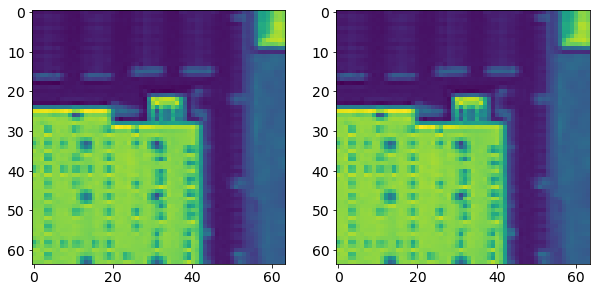

row start: 472, row end: 536
col start: 1478, col end: 1542
imshape: (2352, 3231)


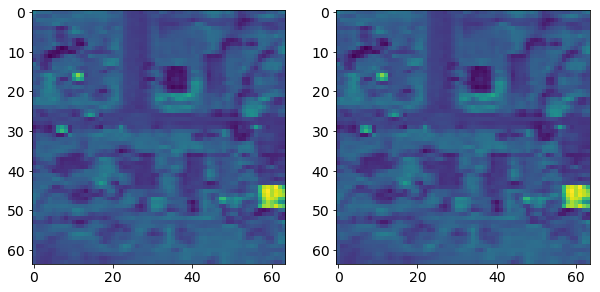

row start: 462, row end: 526
col start: 1905, col end: 1969
imshape: (2352, 3231)


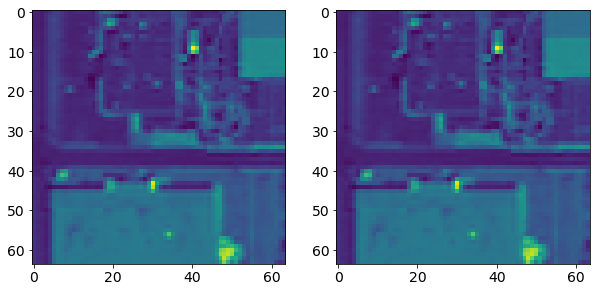

row start: 1336, row end: 1400
col start: 1558, col end: 1622
imshape: (2352, 3231)


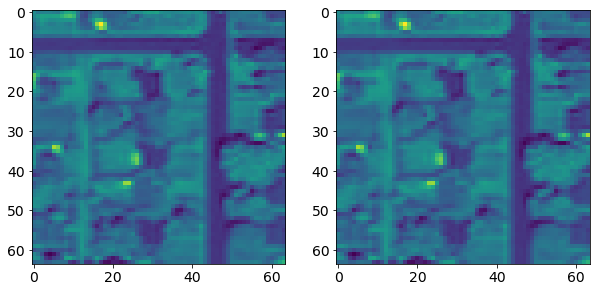

row start: 1658, row end: 1722
col start: 2542, col end: 2606
imshape: (2352, 3231)


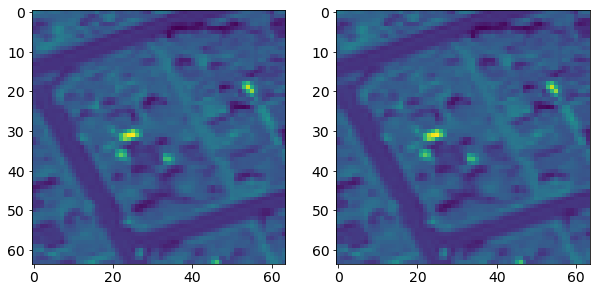

row start: 801, row end: 865
col start: 1514, col end: 1578
imshape: (2352, 3231)


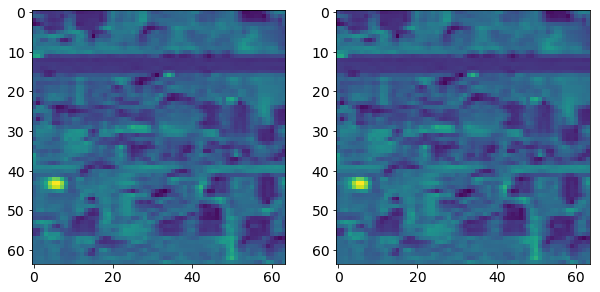

row start: 1616, row end: 1680
col start: 980, col end: 1044
imshape: (2352, 3231)


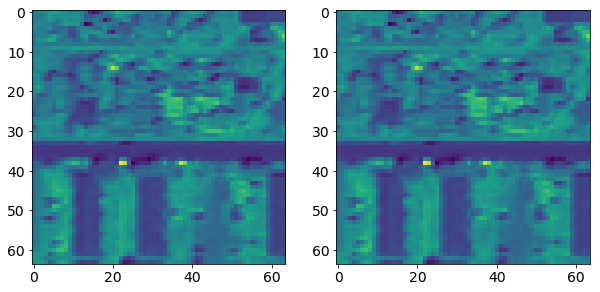

row start: 1444, row end: 1508
col start: 2413, col end: 2477
imshape: (2352, 3231)


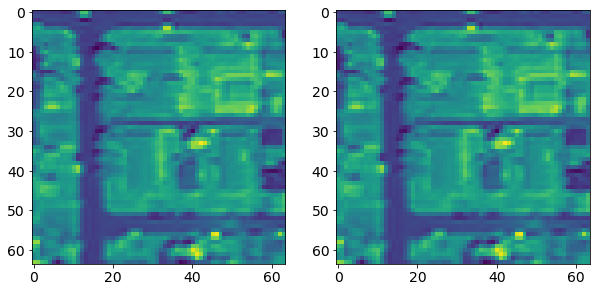

row start: 1593, row end: 1657
col start: 891, col end: 955
imshape: (2352, 3231)


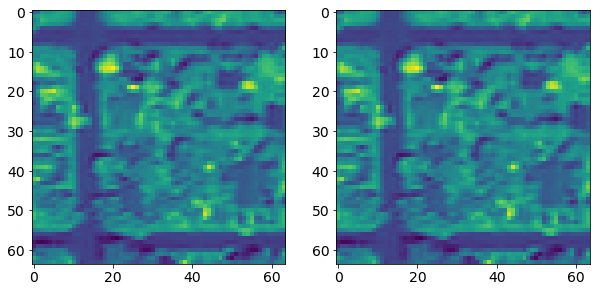

row start: 1268, row end: 1332
col start: 1419, col end: 1483
imshape: (2352, 3231)


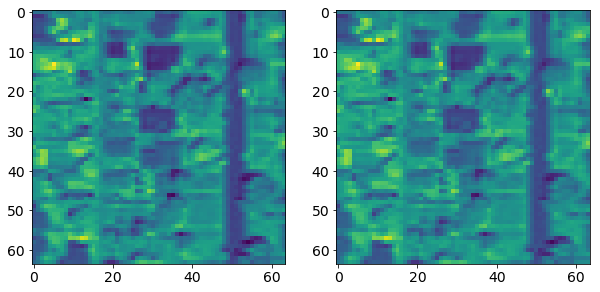

row start: 1355, row end: 1419
col start: 1416, col end: 1480
imshape: (2352, 3231)


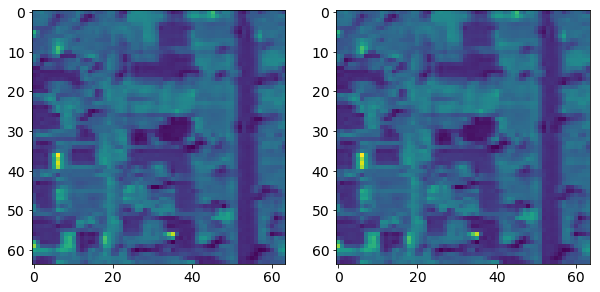

row start: 1250, row end: 1314
col start: 1989, col end: 2053
imshape: (2352, 3231)


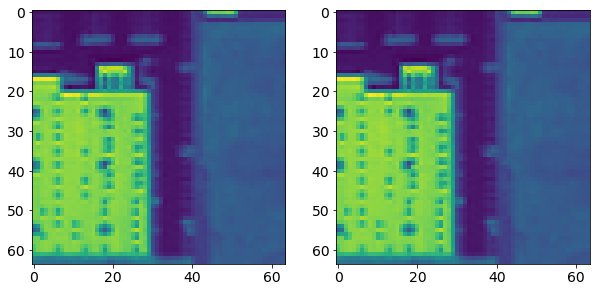

row start: 1793, row end: 1857
col start: 3083, col end: 3147
imshape: (2352, 3231)


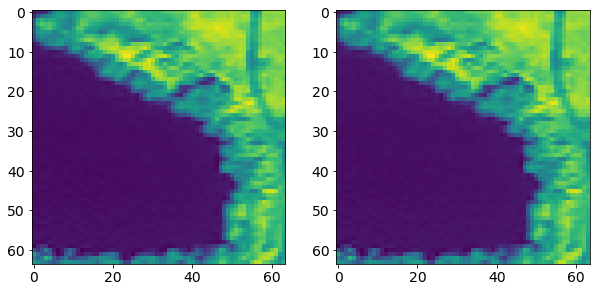

row start: 1537, row end: 1601
col start: 2043, col end: 2107
imshape: (2352, 3231)


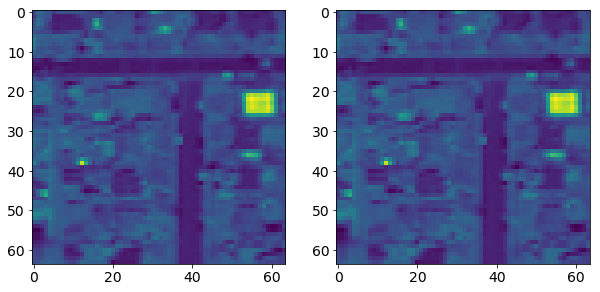

row start: 1211, row end: 1275
col start: 559, col end: 623
imshape: (2352, 3231)


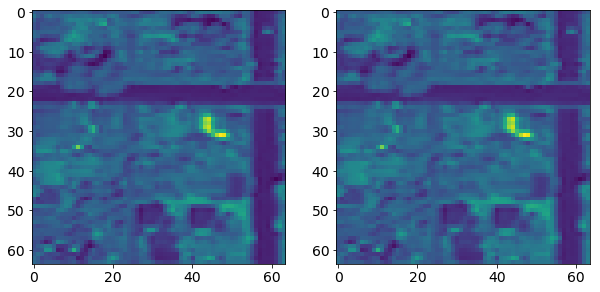

row start: 1446, row end: 1510
col start: 2492, col end: 2556
imshape: (2352, 3231)


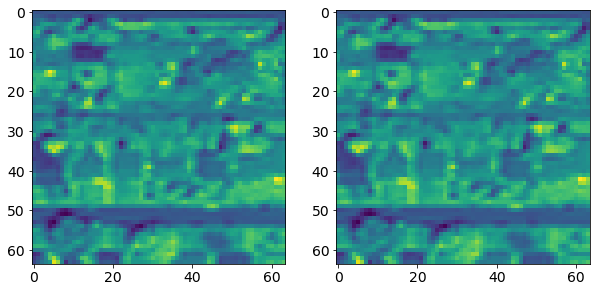

row start: 764, row end: 828
col start: 1484, col end: 1548
imshape: (2352, 3231)


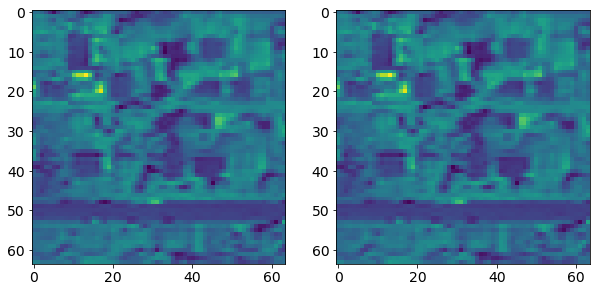

row start: 1265, row end: 1329
col start: 892, col end: 956
imshape: (2352, 3231)


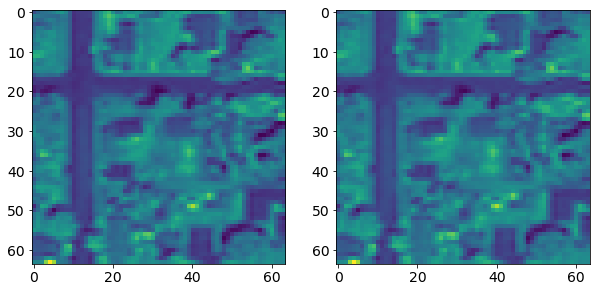

row start: 569, row end: 633
col start: 1870, col end: 1934
imshape: (2352, 3231)


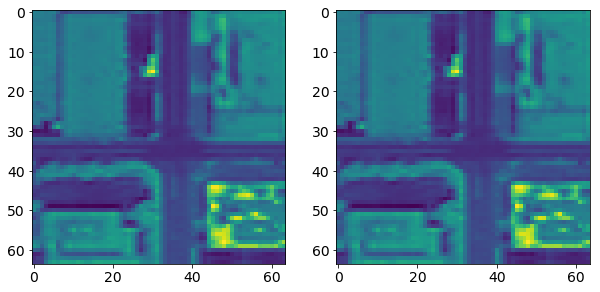

row start: 1248, row end: 1312
col start: 2119, col end: 2183
imshape: (2352, 3231)


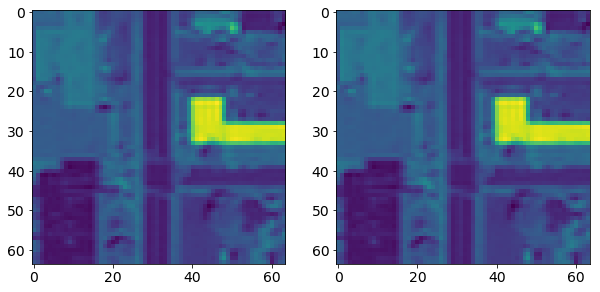

row start: 1156, row end: 1220
col start: 1293, col end: 1357
imshape: (2352, 3231)


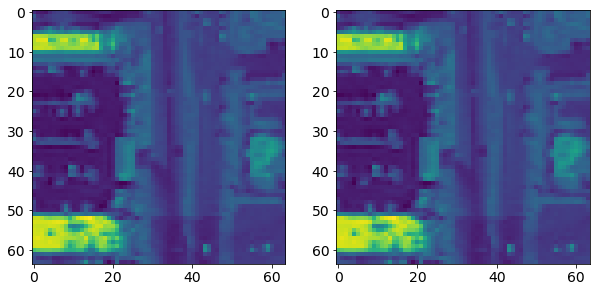

row start: 1160, row end: 1224
col start: 2545, col end: 2609
imshape: (2352, 3231)


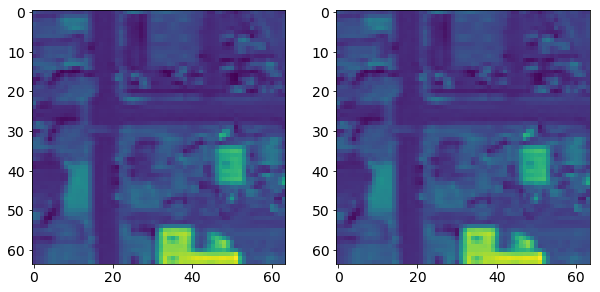

row start: 1357, row end: 1421
col start: 398, col end: 462
imshape: (2352, 3231)


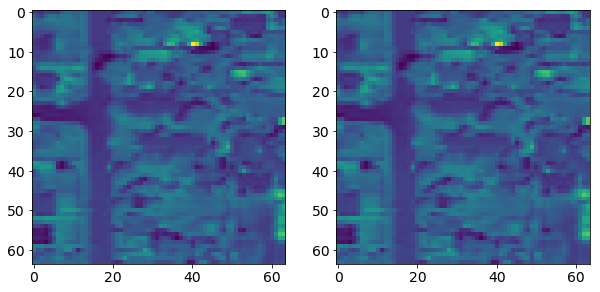

row start: 1588, row end: 1652
col start: 2624, col end: 2688
imshape: (2352, 3231)


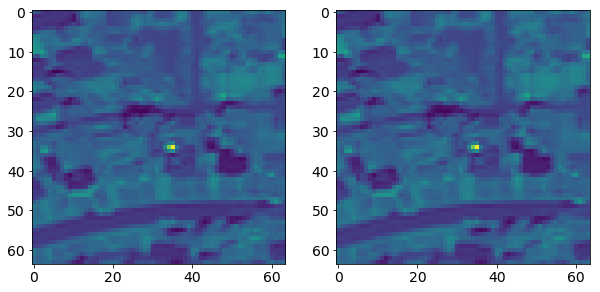

row start: 847, row end: 911
col start: 1984, col end: 2048
imshape: (2352, 3231)


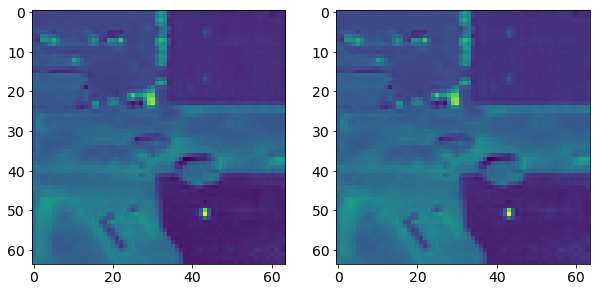

row start: 861, row end: 925
col start: 2206, col end: 2270
imshape: (2352, 3231)


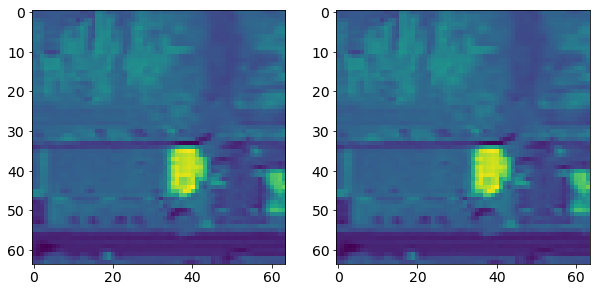

row start: 649, row end: 713
col start: 1398, col end: 1462
imshape: (2352, 3231)


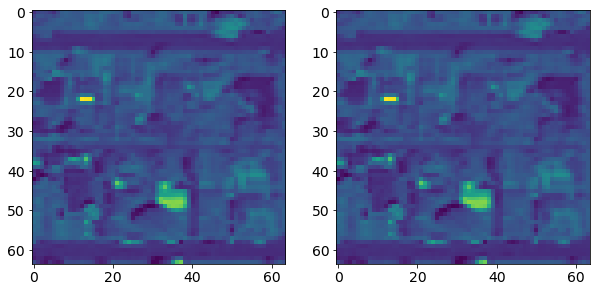

row start: 905, row end: 969
col start: 2555, col end: 2619
imshape: (2352, 3231)


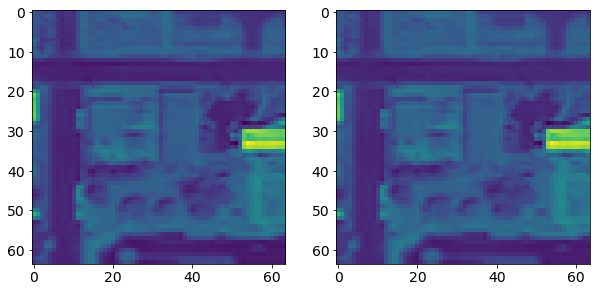

row start: 1635, row end: 1699
col start: 752, col end: 816
imshape: (2352, 3231)


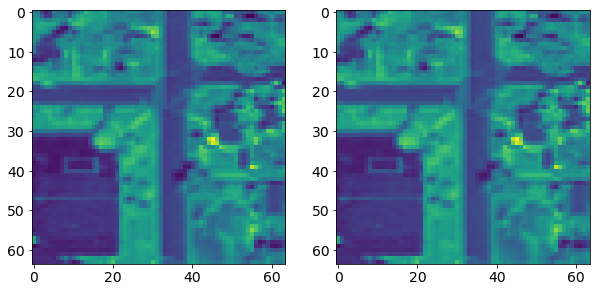

row start: 1535, row end: 1599
col start: 550, col end: 614
imshape: (2352, 3231)


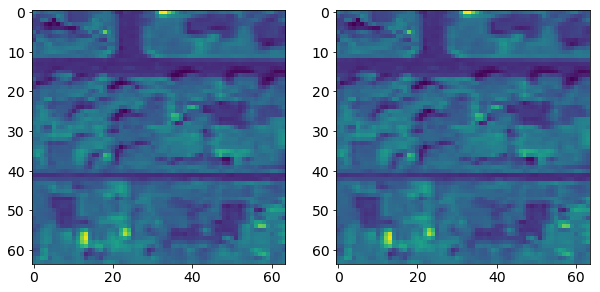

row start: 1696, row end: 1760
col start: 2484, col end: 2548
imshape: (2352, 3231)


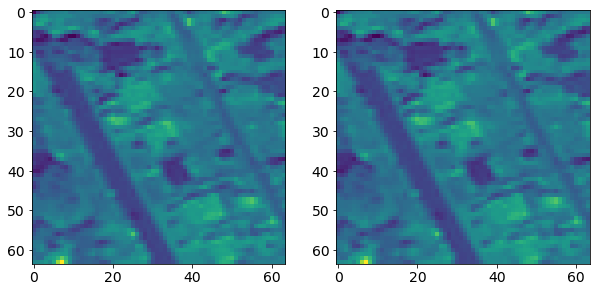

row start: 1147, row end: 1211
col start: 2113, col end: 2177
imshape: (2352, 3231)


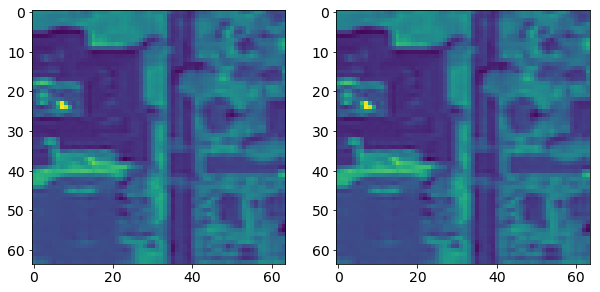

row start: 1553, row end: 1617
col start: 851, col end: 915
imshape: (2352, 3231)


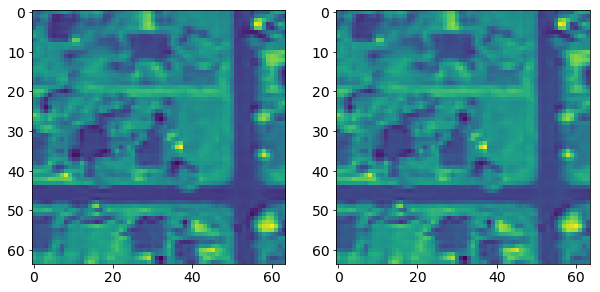

row start: 1294, row end: 1358
col start: 710, col end: 774
imshape: (2352, 3231)


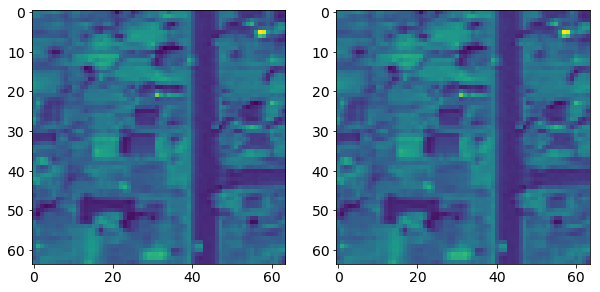

row start: 678, row end: 742
col start: 2288, col end: 2352
imshape: (2352, 3231)


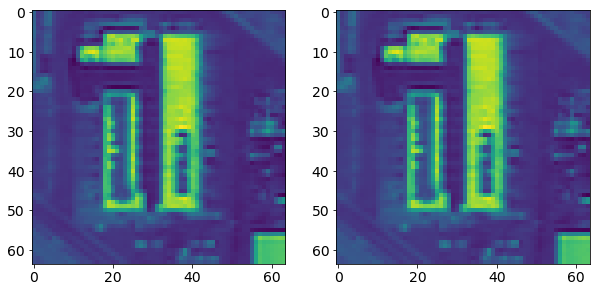

row start: 2034, row end: 2098
col start: 2842, col end: 2906
imshape: (2352, 3231)


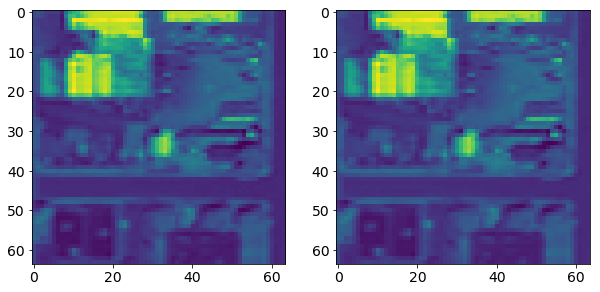

row start: 1414, row end: 1478
col start: 2419, col end: 2483
imshape: (2352, 3231)


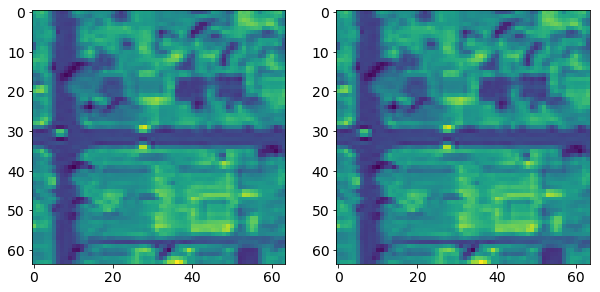

row start: 793, row end: 857
col start: 2330, col end: 2394
imshape: (2352, 3231)


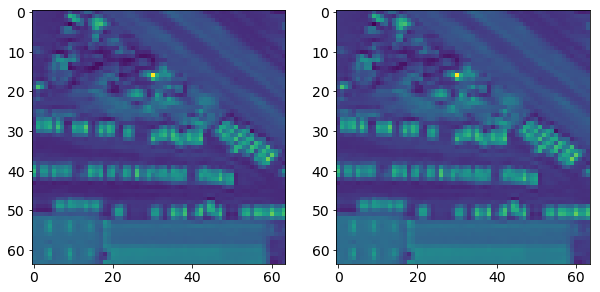

row start: 1154, row end: 1218
col start: 1684, col end: 1748
imshape: (2352, 3231)


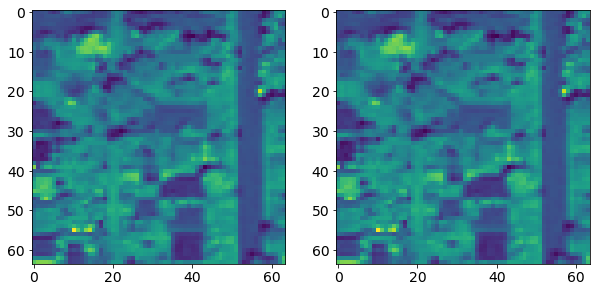

row start: 1349, row end: 1413
col start: 2109, col end: 2173
imshape: (2352, 3231)


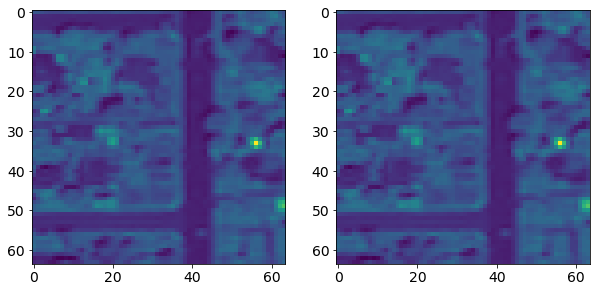

row start: 1458, row end: 1522
col start: 487, col end: 551
imshape: (2352, 3231)


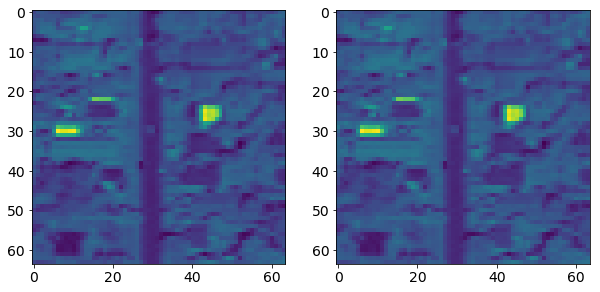

row start: 1524, row end: 1588
col start: 578, col end: 642
imshape: (2352, 3231)


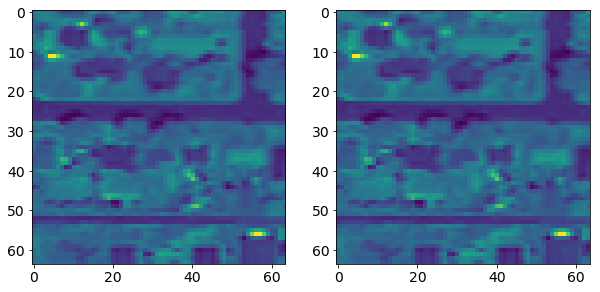

row start: 1743, row end: 1807
col start: 2867, col end: 2931
imshape: (2352, 3231)


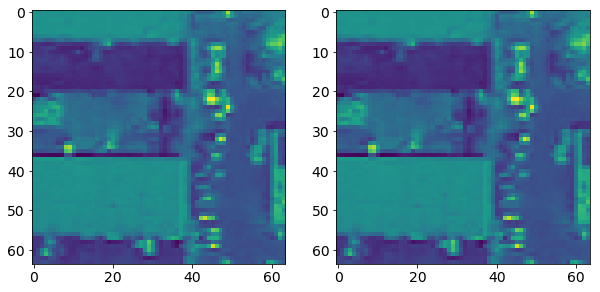

row start: 1397, row end: 1461
col start: 382, col end: 446
imshape: (2352, 3231)


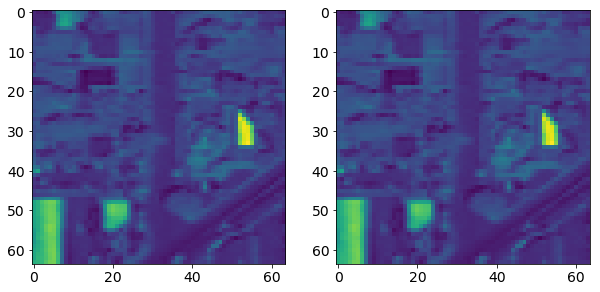

row start: 1177, row end: 1241
col start: 1195, col end: 1259
imshape: (2352, 3231)


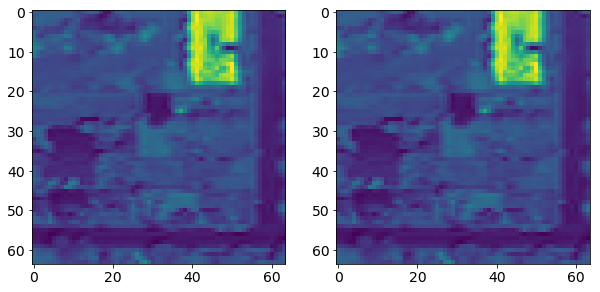

row start: 685, row end: 749
col start: 1717, col end: 1781
imshape: (2352, 3231)


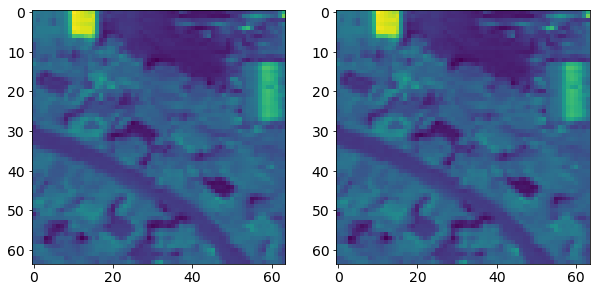

row start: 1147, row end: 1211
col start: 2099, col end: 2163
imshape: (2352, 3231)


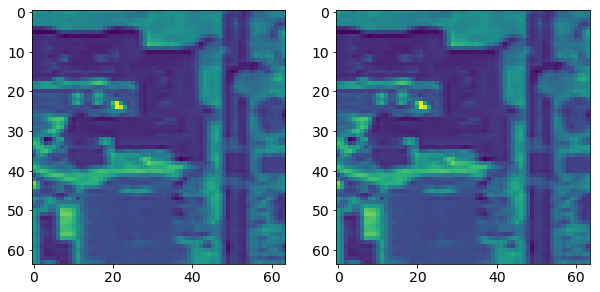

row start: 844, row end: 908
col start: 2023, col end: 2087
imshape: (2352, 3231)


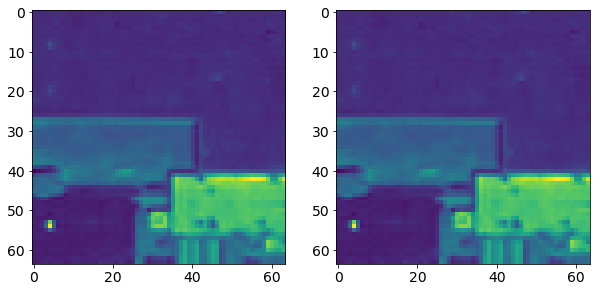

row start: 1821, row end: 1885
col start: 2886, col end: 2950
imshape: (2352, 3231)


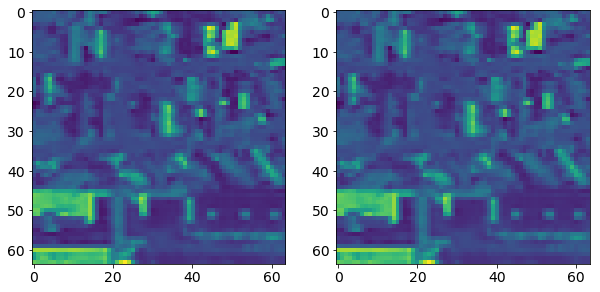

row start: 1072, row end: 1136
col start: 1387, col end: 1451
imshape: (2352, 3231)


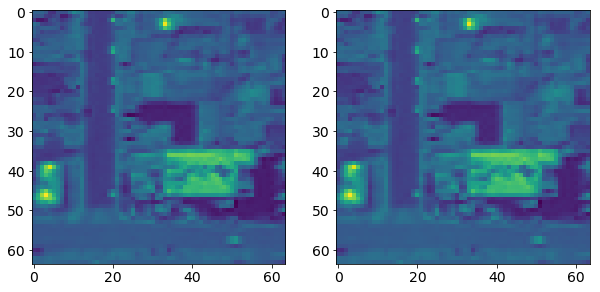

row start: 1489, row end: 1553
col start: 801, col end: 865
imshape: (2352, 3231)


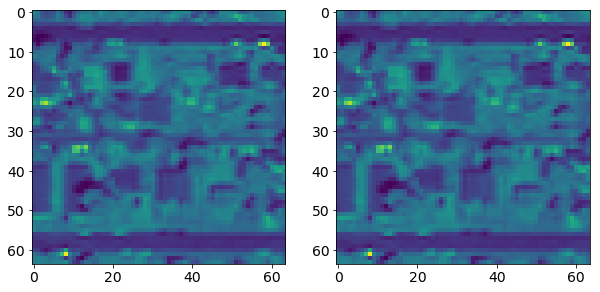

row start: 1848, row end: 1912
col start: 2869, col end: 2933
imshape: (2352, 3231)


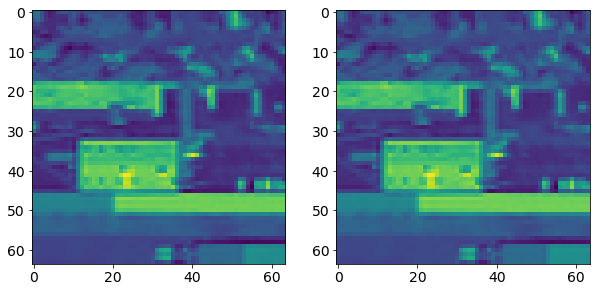

row start: 43, row end: 107
col start: 1609, col end: 1673
imshape: (2352, 3231)


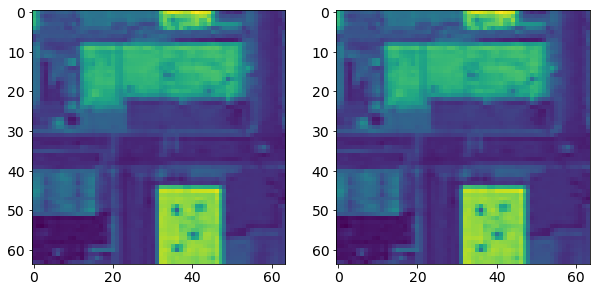

row start: 1016, row end: 1080
col start: 2043, col end: 2107
imshape: (2352, 3231)


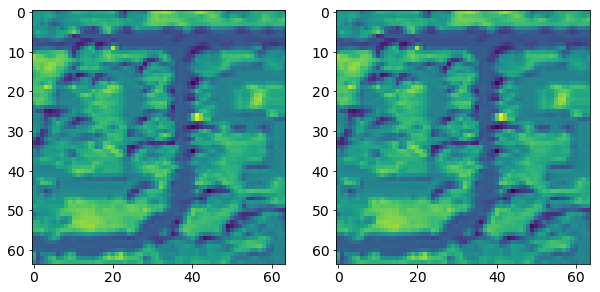

row start: 1109, row end: 1173
col start: 1576, col end: 1640
imshape: (2352, 3231)


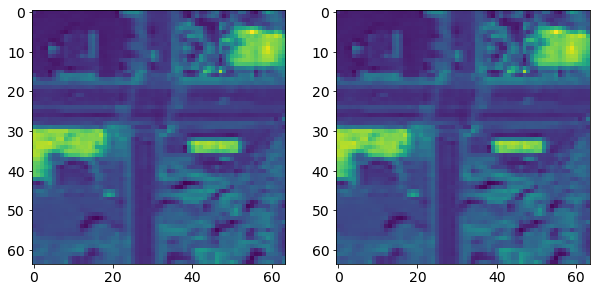

row start: 444, row end: 508
col start: 1724, col end: 1788
imshape: (2352, 3231)


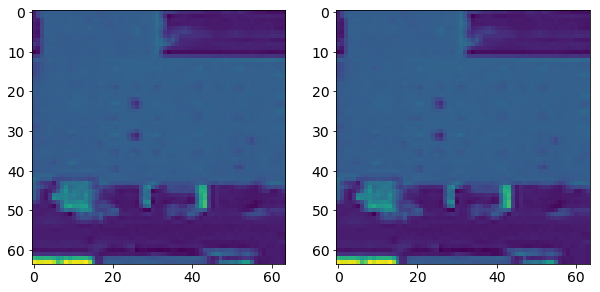

row start: 707, row end: 771
col start: 1618, col end: 1682
imshape: (2352, 3231)


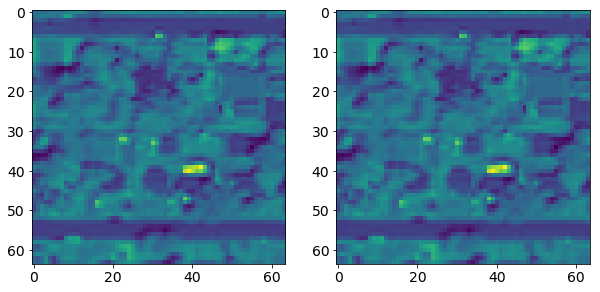

row start: 1574, row end: 1638
col start: 2089, col end: 2153
imshape: (2352, 3231)


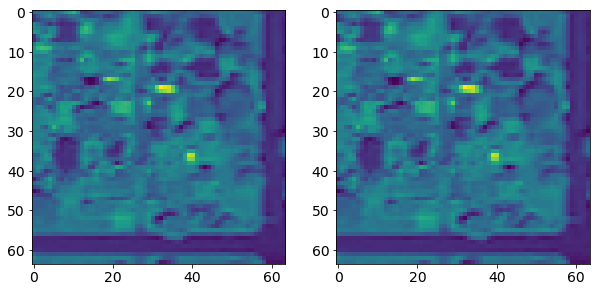

row start: 1339, row end: 1403
col start: 2434, col end: 2498
imshape: (2352, 3231)


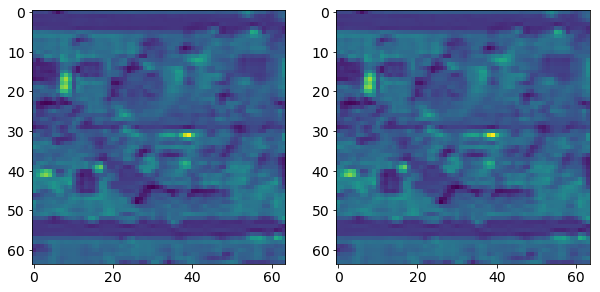

In [21]:
samp_inds = np.unique(np.random.randint(6000, size=100))
for ind in samp_inds:
    
    r,c = coords[ind]
    window_size=64
    r_start = int(r - window_size/2)
    r_end = int(r_start + window_size)
    c_start = int(c - window_size/2)
    c_end = int(c_start + window_size)
    
    print('row start: {}, row end: {}'.format(r_start, r_end))
    print('col start: {}, col end: {}'.format(c_start, c_end))
    print('imshape: {}'.format(img_2m.shape[1:]))
    
    test = img_2m[:,r_start:r_end, c_start:c_end]
    test_toa = img_2m_toa[:,r_start:r_end, c_start:c_end]
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(test[5,:,:])
    ax[1].imshow(test_toa[5,:,:])
    plt.show()

In [ ]:
dg_scene_id

In [37]:
with open('dg_support_coords.txt', 'w') as f:
    for item in coords:
        f.write("{} {}\n".format(item[0], item[1]))

row start: 522, row end: 586
col start: 1870, col end: 1934
imshape: (2352, 3231)


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


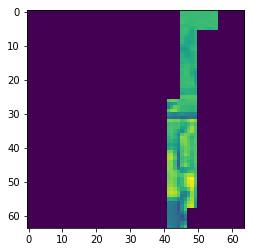

row start: 1659, row end: 1723
col start: 2959, col end: 3023
imshape: (2352, 3231)


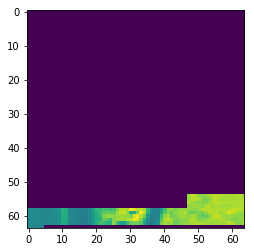

row start: 890, row end: 954
col start: 1523, col end: 1587
imshape: (2352, 3231)


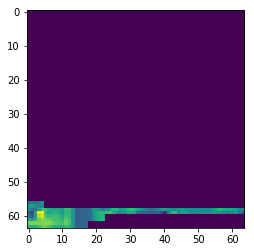

row start: 1732, row end: 1796
col start: 2549, col end: 2613
imshape: (2352, 3231)


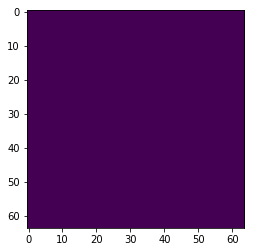

row start: 1388, row end: 1452
col start: 1236, col end: 1300
imshape: (2352, 3231)


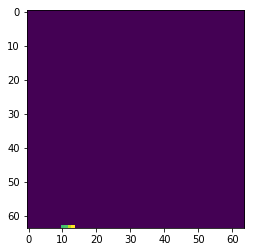

row start: 1353, row end: 1417
col start: 2571, col end: 2635
imshape: (2352, 3231)


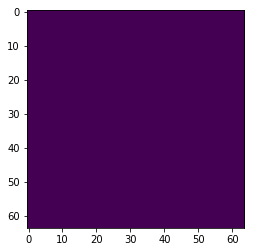

row start: 1501, row end: 1565
col start: 468, col end: 532
imshape: (2352, 3231)


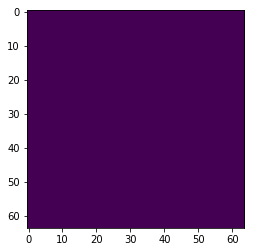

row start: 911, row end: 975
col start: 2132, col end: 2196
imshape: (2352, 3231)


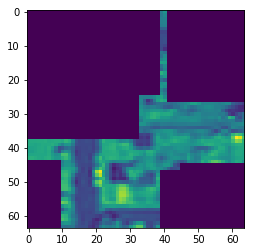

row start: 974, row end: 1038
col start: 2385, col end: 2449
imshape: (2352, 3231)


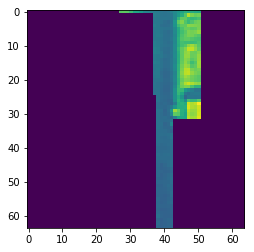

row start: 1468, row end: 1532
col start: 1705, col end: 1769
imshape: (2352, 3231)


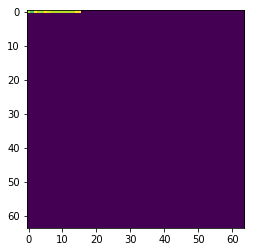

row start: 389, row end: 453
col start: 1759, col end: 1823
imshape: (2352, 3231)


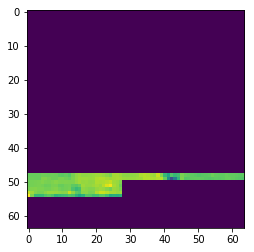

row start: 1493, row end: 1557
col start: 1748, col end: 1812
imshape: (2352, 3231)


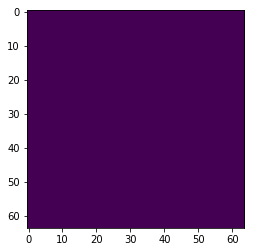

row start: 1016, row end: 1080
col start: 1978, col end: 2042
imshape: (2352, 3231)


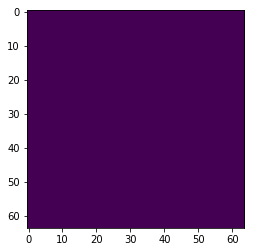

row start: 1910, row end: 1974
col start: 2741, col end: 2805
imshape: (2352, 3231)


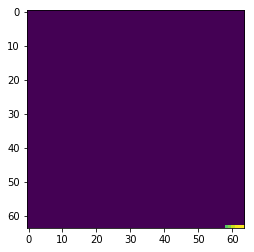

row start: 1206, row end: 1270
col start: 782, col end: 846
imshape: (2352, 3231)


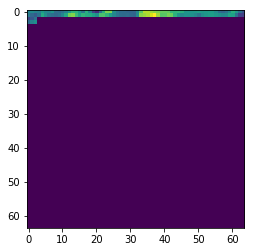

row start: 651, row end: 715
col start: 2109, col end: 2173
imshape: (2352, 3231)


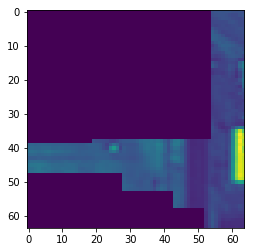

row start: 1193, row end: 1257
col start: 609, col end: 673
imshape: (2352, 3231)


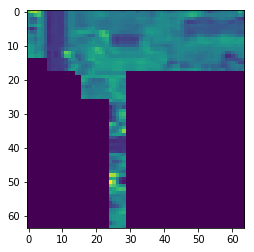

row start: 425, row end: 489
col start: 1886, col end: 1950
imshape: (2352, 3231)


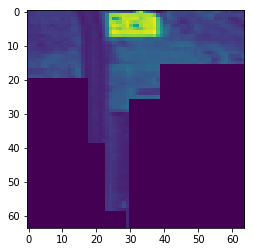

row start: 1399, row end: 1463
col start: 2096, col end: 2160
imshape: (2352, 3231)


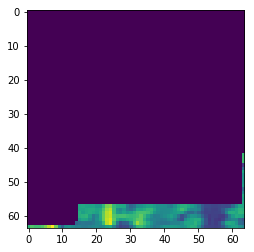

row start: 1625, row end: 1689
col start: 917, col end: 981
imshape: (2352, 3231)


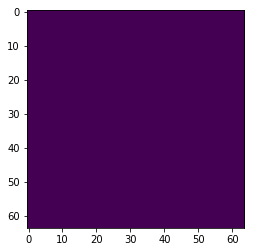

row start: 1205, row end: 1269
col start: 347, col end: 411
imshape: (2352, 3231)


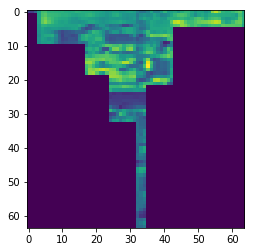

row start: 682, row end: 746
col start: 1830, col end: 1894
imshape: (2352, 3231)


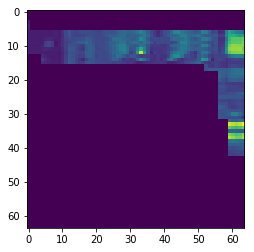

row start: 1197, row end: 1261
col start: 2474, col end: 2538
imshape: (2352, 3231)


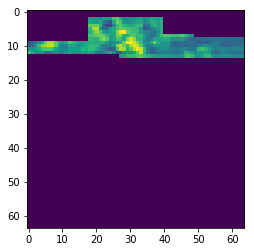

row start: 342, row end: 406
col start: 1769, col end: 1833
imshape: (2352, 3231)


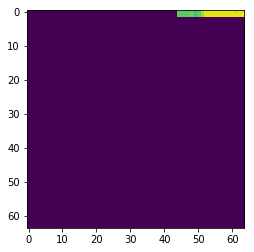

row start: 1617, row end: 1681
col start: 391, col end: 455
imshape: (2352, 3231)


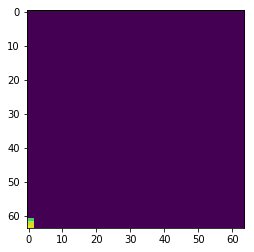

row start: 1564, row end: 1628
col start: 1471, col end: 1535
imshape: (2352, 3231)


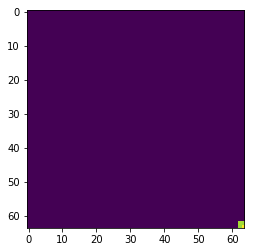

row start: 1188, row end: 1252
col start: 1118, col end: 1182
imshape: (2352, 3231)


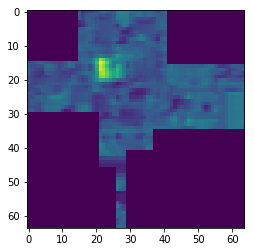

row start: 1105, row end: 1169
col start: 1897, col end: 1961
imshape: (2352, 3231)


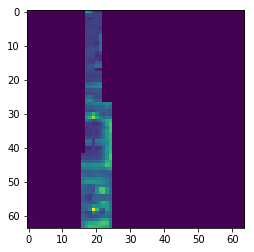

row start: 1285, row end: 1349
col start: 368, col end: 432
imshape: (2352, 3231)


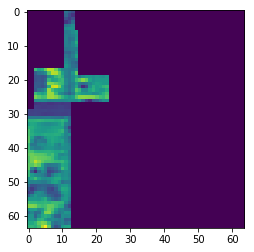

row start: 1102, row end: 1166
col start: 2086, col end: 2150
imshape: (2352, 3231)


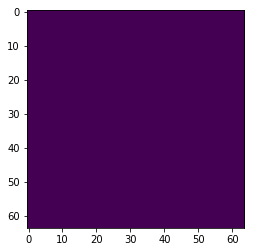

row start: 992, row end: 1056
col start: 2332, col end: 2396
imshape: (2352, 3231)


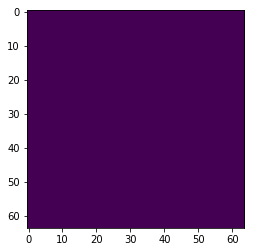

row start: 523, row end: 587
col start: 1431, col end: 1495
imshape: (2352, 3231)


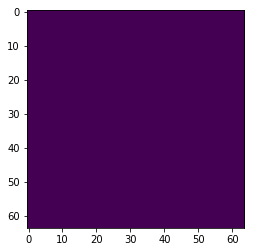

row start: 150, row end: 214
col start: 1747, col end: 1811
imshape: (2352, 3231)


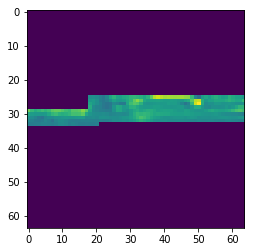

row start: 1685, row end: 1749
col start: 923, col end: 987
imshape: (2352, 3231)


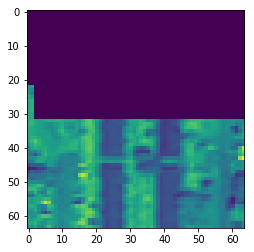

row start: 903, row end: 967
col start: 1384, col end: 1448
imshape: (2352, 3231)


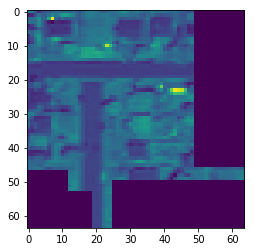

row start: 1212, row end: 1276
col start: 586, col end: 650
imshape: (2352, 3231)


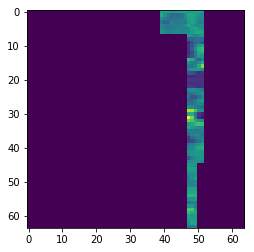

row start: 2154, row end: 2218
col start: 2985, col end: 3049
imshape: (2352, 3231)


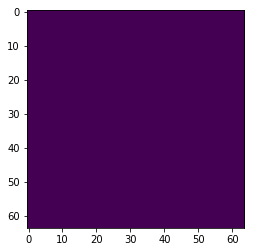

row start: 327, row end: 391
col start: 1748, col end: 1812
imshape: (2352, 3231)


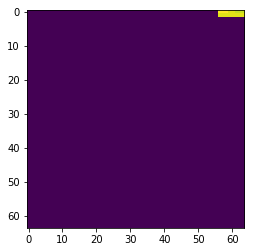

row start: 472, row end: 536
col start: 1478, col end: 1542
imshape: (2352, 3231)


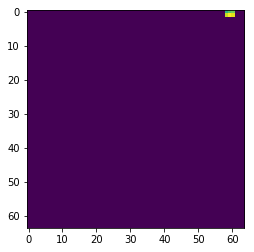

row start: 1323, row end: 1387
col start: 1290, col end: 1354
imshape: (2352, 3231)


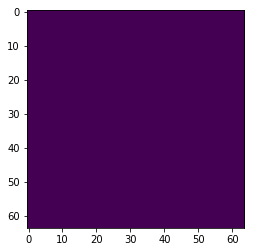

row start: 1345, row end: 1409
col start: 884, col end: 948
imshape: (2352, 3231)


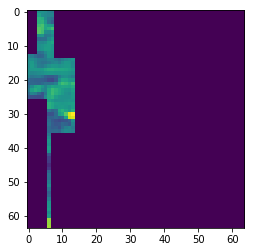

row start: 1155, row end: 1219
col start: 2666, col end: 2730
imshape: (2352, 3231)


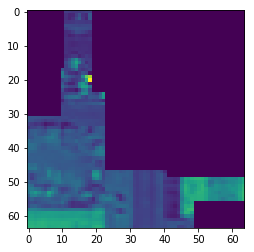

row start: 1628, row end: 1692
col start: 1193, col end: 1257
imshape: (2352, 3231)


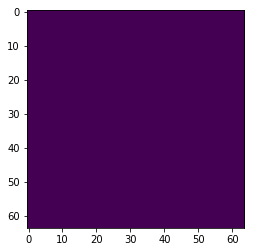

row start: 1887, row end: 1951
col start: 2701, col end: 2765
imshape: (2352, 3231)


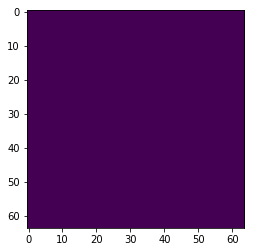

row start: 1202, row end: 1266
col start: 407, col end: 471
imshape: (2352, 3231)


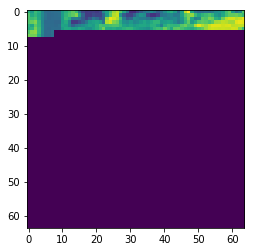

row start: 644, row end: 708
col start: 2234, col end: 2298
imshape: (2352, 3231)


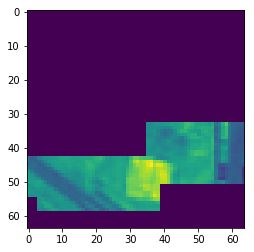

row start: 249, row end: 313
col start: 1745, col end: 1809
imshape: (2352, 3231)


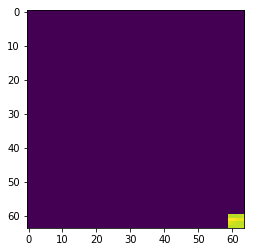

row start: 1142, row end: 1206
col start: 1362, col end: 1426
imshape: (2352, 3231)


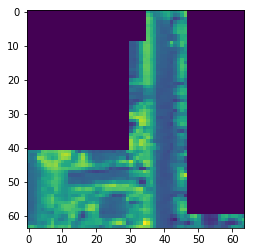

row start: 1216, row end: 1280
col start: 431, col end: 495
imshape: (2352, 3231)


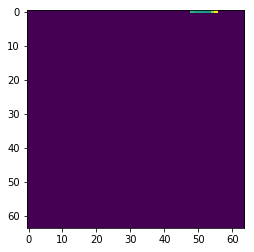

row start: 1154, row end: 1218
col start: 1118, col end: 1182
imshape: (2352, 3231)


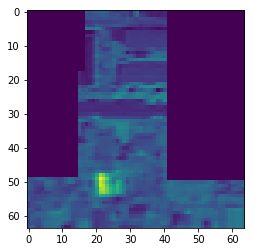

row start: 267, row end: 331
col start: 1584, col end: 1648
imshape: (2352, 3231)


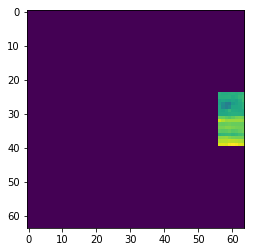

row start: 1526, row end: 1590
col start: 594, col end: 658
imshape: (2352, 3231)


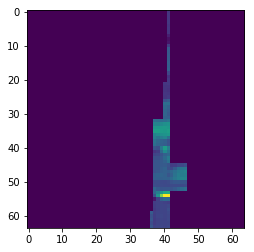

row start: 569, row end: 633
col start: 1870, col end: 1934
imshape: (2352, 3231)


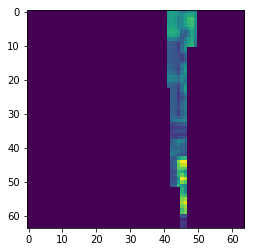

row start: 1484, row end: 1548
col start: 2092, col end: 2156
imshape: (2352, 3231)


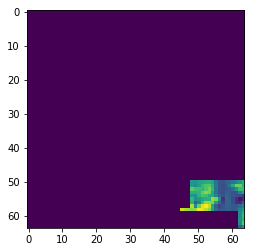

row start: 1126, row end: 1190
col start: 2587, col end: 2651
imshape: (2352, 3231)


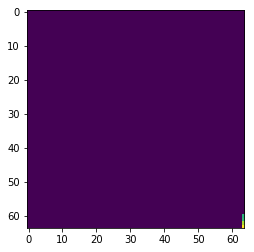

row start: 1649, row end: 1713
col start: 306, col end: 370
imshape: (2352, 3231)


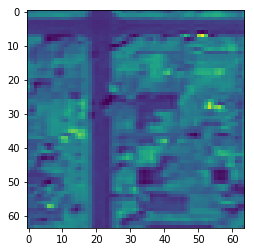

row start: 975, row end: 1039
col start: 2254, col end: 2318
imshape: (2352, 3231)


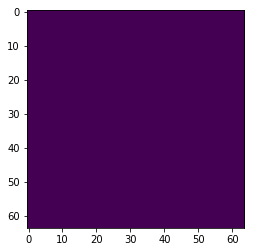

row start: 597, row end: 661
col start: 1844, col end: 1908
imshape: (2352, 3231)


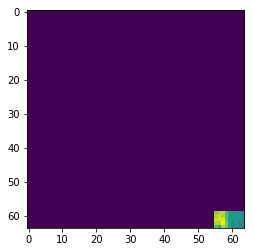

row start: 643, row end: 707
col start: 1952, col end: 2016
imshape: (2352, 3231)


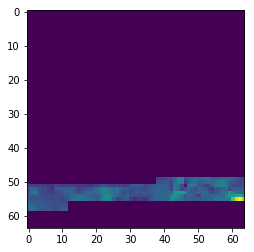

row start: 1261, row end: 1325
col start: 1796, col end: 1860
imshape: (2352, 3231)


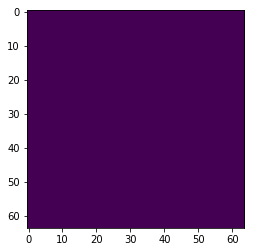

row start: 556, row end: 620
col start: 1456, col end: 1520
imshape: (2352, 3231)


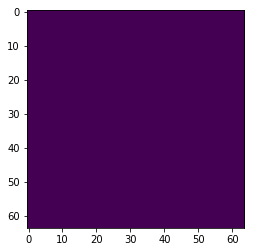

row start: 541, row end: 605
col start: 1574, col end: 1638
imshape: (2352, 3231)


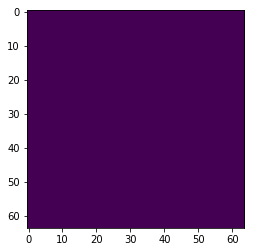

row start: 319, row end: 383
col start: 1582, col end: 1646
imshape: (2352, 3231)


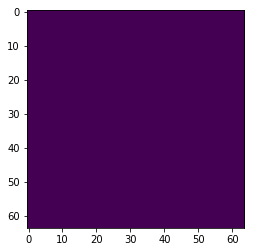

row start: 1481, row end: 1545
col start: 2660, col end: 2724
imshape: (2352, 3231)


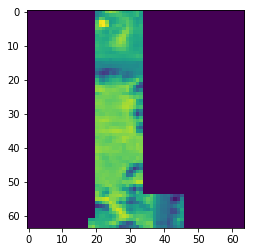

row start: 1896, row end: 1960
col start: 2739, col end: 2803
imshape: (2352, 3231)


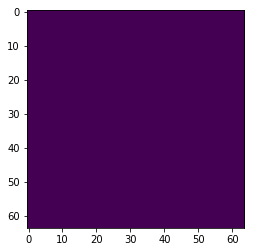

row start: 1528, row end: 1592
col start: 566, col end: 630
imshape: (2352, 3231)


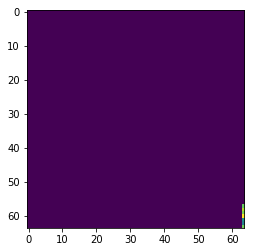

row start: 828, row end: 892
col start: 1523, col end: 1587
imshape: (2352, 3231)


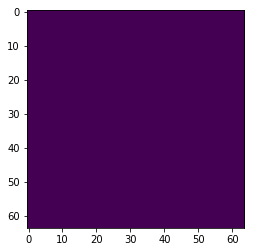

row start: 1181, row end: 1245
col start: 1709, col end: 1773
imshape: (2352, 3231)


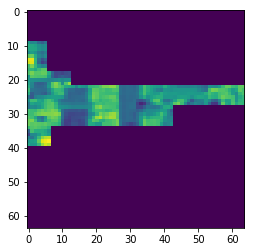

row start: 1023, row end: 1087
col start: 2115, col end: 2179
imshape: (2352, 3231)


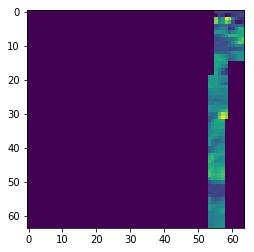

row start: 273, row end: 337
col start: 1687, col end: 1751
imshape: (2352, 3231)


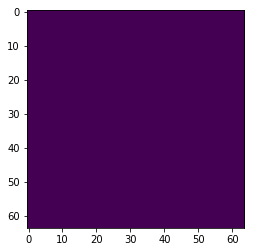

row start: 1047, row end: 1111
col start: 1712, col end: 1776
imshape: (2352, 3231)


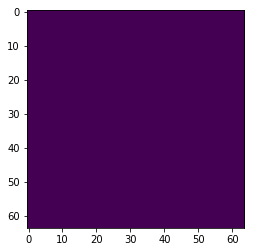

row start: 159, row end: 223
col start: 1461, col end: 1525
imshape: (2352, 3231)


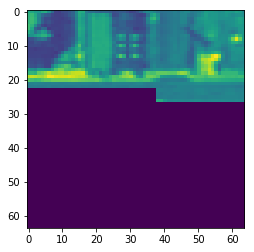

row start: 1687, row end: 1751
col start: 2813, col end: 2877
imshape: (2352, 3231)


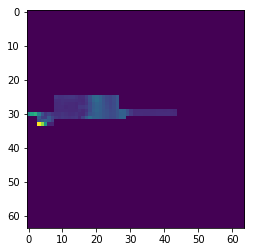

row start: 927, row end: 991
col start: 1776, col end: 1840
imshape: (2352, 3231)


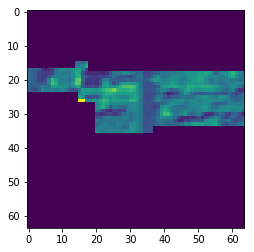

row start: 835, row end: 899
col start: 1355, col end: 1419
imshape: (2352, 3231)


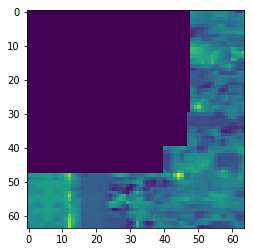

row start: 1898, row end: 1962
col start: 2897, col end: 2961
imshape: (2352, 3231)


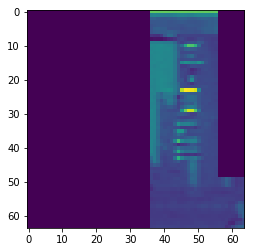

row start: 1261, row end: 1325
col start: 2552, col end: 2616
imshape: (2352, 3231)


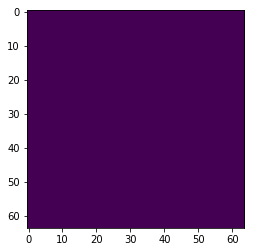

row start: 678, row end: 742
col start: 2278, col end: 2342
imshape: (2352, 3231)


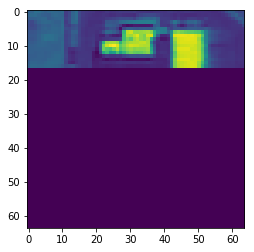

row start: 1514, row end: 1578
col start: 2035, col end: 2099
imshape: (2352, 3231)


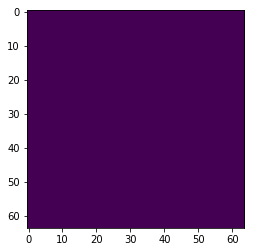

row start: 1271, row end: 1335
col start: 658, col end: 722
imshape: (2352, 3231)


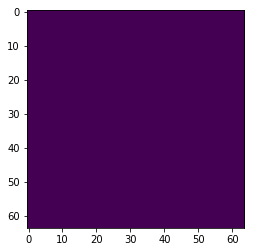

row start: 717, row end: 781
col start: 2144, col end: 2208
imshape: (2352, 3231)


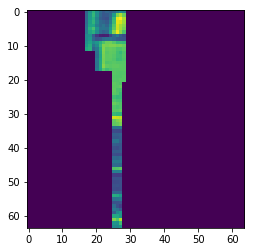

row start: 773, row end: 837
col start: 1933, col end: 1997
imshape: (2352, 3231)


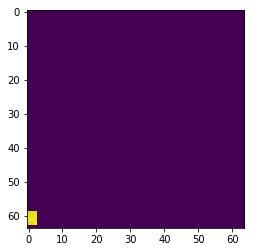

row start: 1591, row end: 1655
col start: 561, col end: 625
imshape: (2352, 3231)


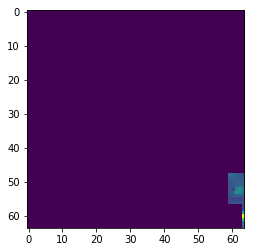

row start: 1229, row end: 1293
col start: 1213, col end: 1277
imshape: (2352, 3231)


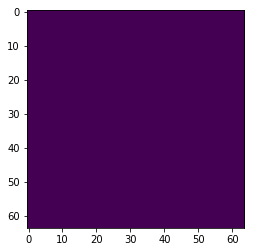

row start: 974, row end: 1038
col start: 1709, col end: 1773
imshape: (2352, 3231)


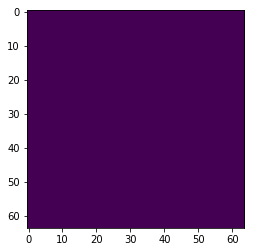

row start: 1510, row end: 1574
col start: 1092, col end: 1156
imshape: (2352, 3231)


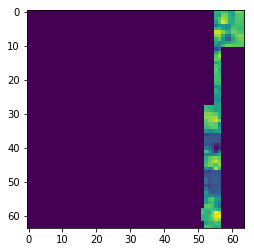

row start: 1381, row end: 1445
col start: 2561, col end: 2625
imshape: (2352, 3231)


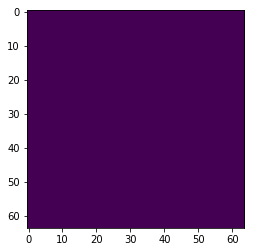

row start: 1799, row end: 1863
col start: 2890, col end: 2954
imshape: (2352, 3231)


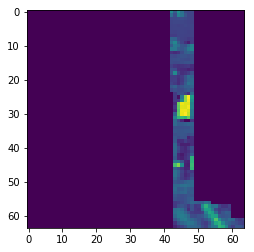

row start: 1181, row end: 1245
col start: 2701, col end: 2765
imshape: (2352, 3231)


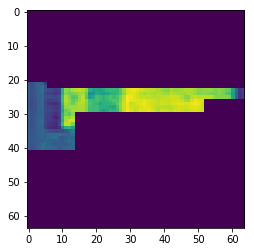

row start: 1454, row end: 1518
col start: 2510, col end: 2574
imshape: (2352, 3231)


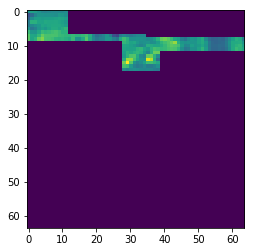

row start: 1589, row end: 1653
col start: 1105, col end: 1169
imshape: (2352, 3231)


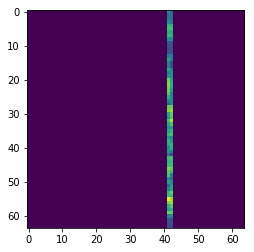

row start: 1826, row end: 1890
col start: 2811, col end: 2875
imshape: (2352, 3231)


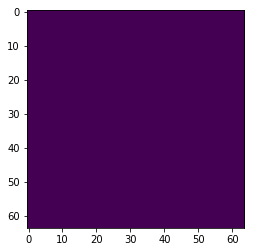

row start: 880, row end: 944
col start: 2294, col end: 2358
imshape: (2352, 3231)


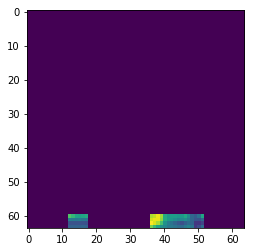

row start: 1290, row end: 1354
col start: 2756, col end: 2820
imshape: (2352, 3231)


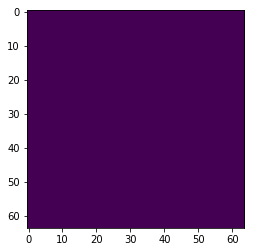

row start: 964, row end: 1028
col start: 1803, col end: 1867
imshape: (2352, 3231)


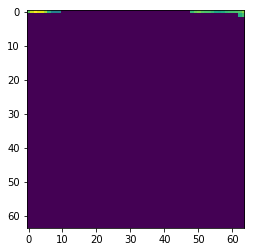

row start: 1466, row end: 1530
col start: 2880, col end: 2944
imshape: (2352, 3231)


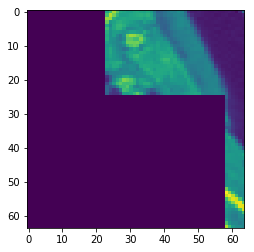

row start: 1194, row end: 1258
col start: 1482, col end: 1546
imshape: (2352, 3231)


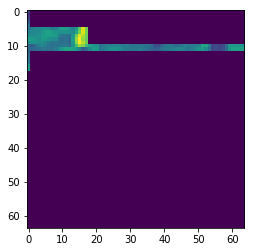

row start: 2085, row end: 2149
col start: 2947, col end: 3011
imshape: (2352, 3231)


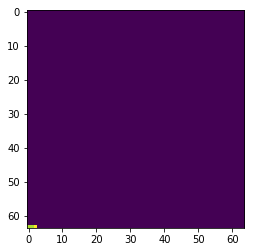

row start: 1411, row end: 1475
col start: 2461, col end: 2525
imshape: (2352, 3231)


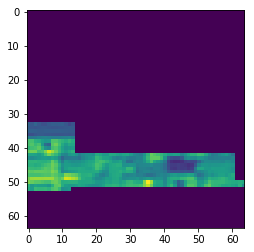

row start: 1457, row end: 1521
col start: 2111, col end: 2175
imshape: (2352, 3231)


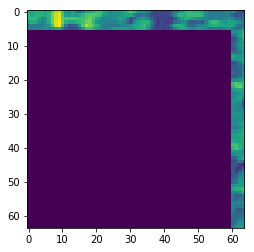

In [18]:
##### debug code for DG support
from gbdxtools import CatalogImage
import numpy as np
from matplotlib import pyplot as plt

# get the dask array for the 8 band MS image
shp_bounds = (-105.04798605513851, 39.690173358281925, -104.99237692378261, 39.73066280731016)
dg_scene_id = '1030010057062200'
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)

# load the row/cols
coords = np.loadtxt('dg_support_coords.txt')

samp_inds = np.unique(np.random.randint(6000, size=100))
for ind in samp_inds:
    
    r,c = coords[ind]
    r = int(r)
    c = int(c)
    window_size=64
    r_start = int(r - window_size/2)
    r_end = int(r_start + window_size)
    c_start = int(c - window_size/2)
    c_end = int(c_start + window_size)
    
    print('row start: {}, row end: {}'.format(r_start, r_end))
    print('col start: {}, col end: {}'.format(c_start, c_end))
    print('imshape: {}'.format(img_2m.shape[1:]))
    
    test = img_2m[:,r_start:r_end, c_start:c_end]
    plt.imshow(test[5,:,:])
    plt.show()